# Importation Data

In [1]:
import pandas as pd 
import yfinance as yf 
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn import metrics
import plotly.express as px
import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras_tuner import RandomSearch
from pathlib import Path
from tensorflow.keras import  mixed_precision, layers

In [2]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("CPU devices:", tf.config.list_physical_devices('CPU'))
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# Mixed precision (gain VRAM + vitesse si GPU récent)
mixed_precision.set_global_policy('mixed_float16')

# Optional: limiter verbosité TF
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

TF version: 2.20.0
CPU devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU devices: []


In [3]:
daily_data = pd.DataFrame()
data_SP500 = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_SP500.parquet')
data_NDX = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_NASDAQ.parquet')
data_MP = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_MP.parquet')
data_Crypto = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_Crypto.parquet')
daily_data = pd.concat([data_SP500, data_NDX, data_MP, data_Crypto], ignore_index=True)
daily_data = daily_data.drop_duplicates(subset=['Ticker', 'Date'])
daily_data

Price,Date,Close,High,Low,Open,Volume,Ticker,Adj Close
0,1999-11-18,26.399939,29.999932,23.999944,27.299935,6.254638e+07,A,NaN
1,1999-11-19,24.224939,25.799935,23.887440,25.762434,1.523415e+07,A,NaN
2,1999-11-22,26.399939,26.399939,24.037443,24.787442,6.577870e+06,A,NaN
3,1999-11-23,23.999937,26.174932,23.999937,25.499933,5.975611e+06,A,NaN
4,1999-11-24,24.637444,25.162443,23.999944,24.074945,4.843231e+06,A,NaN
...,...,...,...,...,...,...,...,...
4307646,2025-09-11,0.255658,0.256856,0.244302,0.245392,3.760659e+09,DOGE-USD,NaN
4307647,2025-09-12,0.275428,0.278387,0.255165,0.255652,4.643520e+09,DOGE-USD,NaN
4307648,2025-09-13,0.289464,0.305642,0.273147,0.275420,9.024886e+09,DOGE-USD,NaN
4307649,2025-09-14,0.278590,0.294212,0.273188,0.289463,5.708226e+09,DOGE-USD,NaN


In [4]:
#start_date = "1990-01-03"
#final_date = "2025-07-16"

daily_data = daily_data.sort_values(by=['Date'], ascending = True)

# Accéder à l'index de la colonne 'Date'
#s = daily_data[daily_data['Date'] == start_date].index[0]
#f = daily_data[daily_data['Date'] == final_date].index[0]

# Filtrer les données à partir de la date spécifiée
#daily_data = daily_data.loc[s:]

daily_data

Price,Date,Close,High,Low,Open,Volume,Ticker,Adj Close
398523,1976-07-01,0.440307,0.455666,0.440307,0.440307,2.824000e+05,BAC,NaN
410926,1976-07-01,0.159507,0.159507,0.157715,0.157715,7.040000e+04,BALL,NaN
2226823,1976-07-01,0.109001,0.112029,0.109001,0.109001,2.073600e+06,MDT,NaN
1982242,1976-07-01,0.205049,0.206582,0.203823,0.206275,1.939200e+06,KO,NaN
935410,1976-07-01,0.865298,0.871009,0.862442,0.868154,9.496000e+05,CVX,NaN
...,...,...,...,...,...,...,...,...
4265320,2025-09-15,63.130001,63.240002,62.520000,62.970001,9.724000e+03,CL=F,NaN
4259028,2025-09-15,42.674999,42.840000,42.500000,42.724998,8.619000e+03,SI=F,NaN
4252743,2025-09-15,3679.500000,3684.300049,3662.800049,3680.199951,3.597300e+04,GC=F,NaN
4291325,2025-09-15,116292.226562,116728.804688,114914.414062,115377.843750,3.610513e+10,BTC-USD,NaN


In [5]:
#Date au format Date
daily_data['Date'] = pd.to_datetime(daily_data['Date'])

# Définir la colonne 'Date' comme index
daily_data.set_index('Date', inplace=True)

daily_data

Price,Close,High,Low,Open,Volume,Ticker,Adj Close
Date,,,,,,,
1976-07-01,0.440307,0.455666,0.440307,0.440307,2.824000e+05,BAC,NaN
1976-07-01,0.159507,0.159507,0.157715,0.157715,7.040000e+04,BALL,NaN
1976-07-01,0.109001,0.112029,0.109001,0.109001,2.073600e+06,MDT,NaN
1976-07-01,0.205049,0.206582,0.203823,0.206275,1.939200e+06,KO,NaN
1976-07-01,0.865298,0.871009,0.862442,0.868154,9.496000e+05,CVX,NaN
...,...,...,...,...,...,...,...
2025-09-15,63.130001,63.240002,62.520000,62.970001,9.724000e+03,CL=F,NaN
2025-09-15,42.674999,42.840000,42.500000,42.724998,8.619000e+03,SI=F,NaN
2025-09-15,3679.500000,3684.300049,3662.800049,3680.199951,3.597300e+04,GC=F,NaN


In [6]:

# Rééchantillonner les données en fréquence Annuelle
yearly_data = daily_data.groupby("Ticker").resample('YE').agg({
    'Open': 'first',   # Premier prix d'ouverture du mois
    'High': 'max',     # Plus haut du mois
    'Low': 'min',      # Plus bas du mois
    'Close': 'last',   # Dernier prix de clôture du mois
    'Volume': 'sum',   # Somme du volume sur le mois
}).reset_index()
yearly_data

Price,Ticker,Date,Open,High,Low,Close,Volume
0,A,1999-12-31,27.299935,47.999879,23.887440,46.387383,1.721999e+08
1,A,2000-12-31,47.249898,97.199750,22.837444,32.849915,1.068041e+09
2,A,2001-12-31,32.324922,40.799910,10.799970,17.105959,8.211647e+08
3,A,2002-12-31,17.105964,22.799940,6.299984,10.775978,9.324905e+08
4,A,2003-12-31,10.931972,17.651957,6.779983,17.543957,8.176573e+08
...,...,...,...,...,...,...,...
15932,ZTS,2021-12-31,159.257303,240.462694,135.876367,235.407852,4.287198e+08
15933,ZTS,2022-12-31,233.729319,234.645765,120.642194,142.409286,5.492331e+08
15934,ZTS,2023-12-31,144.459678,198.004646,137.521399,193.542877,4.854201e+08
15935,ZTS,2024-12-31,191.993503,197.922089,142.720087,161.353073,6.381460e+08


In [7]:

# Rééchantillonner les données en fréquence mensuelle
monthly_data = daily_data.groupby("Ticker").resample('ME').agg({
    'Open': 'first',   # Premier prix d'ouverture du mois
    'High': 'max',     # Plus haut du mois
    'Low': 'min',      # Plus bas du mois
    'Close': 'last',   # Dernier prix de clôture du mois
    'Volume': 'sum',   # Somme du volume sur le mois
}).reset_index()
monthly_data


Price,Ticker,Date,Open,High,Low,Close,Volume
0,A,1999-11-30,27.299935,29.999932,23.887440,25.312433,105291489.0
1,A,1999-12-31,25.312438,47.999879,24.599949,46.387383,66908419.0
2,A,2000-01-31,47.249898,47.362399,34.874915,39.712406,44880832.0
3,A,2000-02-29,39.749901,69.262312,39.749901,62.324841,32938000.0
4,A,2000-03-31,62.699824,97.199750,53.999844,62.399818,57679666.0
...,...,...,...,...,...,...,...
186639,ZTS,2025-05-31,156.028266,169.224131,148.493472,168.068008,67452500.0
186640,ZTS,2025-06-30,167.260719,171.656013,153.745890,155.430267,58660600.0
186641,ZTS,2025-07-31,154.423634,161.230870,145.309998,145.789993,70386200.0
186642,ZTS,2025-08-31,146.179993,160.479996,144.250000,156.399994,66191300.0


In [8]:

# Rééchantillonner les données en fréquence semestrielle
weekly_data = daily_data.groupby("Ticker").resample('W').agg({
    'Open': 'first',   # Premier prix d'ouverture du mois
    'High': 'max',     # Plus haut du mois
    'Low': 'min',      # Plus bas du mois
    'Close': 'last',   # Dernier prix de clôture du mois
    'Volume': 'sum',   # Somme du volume sur le mois
}).reset_index()
weekly_data


Price,Ticker,Date,Open,High,Low,Close,Volume
0,A,1999-11-21,27.299935,29.999932,23.887440,24.224939,77780526.0
1,A,1999-11-28,24.787442,26.399939,23.999937,24.712440,19126178.0
2,A,1999-12-05,24.599941,27.412429,24.337441,26.699930,17453611.0
3,A,1999-12-12,27.149936,27.862433,26.587434,26.849932,10048404.0
4,A,1999-12-19,27.299925,28.349922,24.599949,27.562433,15559180.0
...,...,...,...,...,...,...,...
809572,ZTS,2025-08-17,147.669998,155.100006,147.350006,154.110001,15245700.0
809573,ZTS,2025-08-24,154.000000,160.479996,151.600006,156.619995,12640900.0
809574,ZTS,2025-08-31,156.759995,157.210007,153.289993,156.399994,10709200.0
809575,ZTS,2025-09-07,154.979996,155.380005,151.350006,153.320007,7327400.0


# Labelling

In [9]:
daily_data = daily_data.reset_index()

### Target Pourcentage

In [10]:
def Best_And_Worst_Stocks_Pourcentage(snp_prices, pourcentage, window):
    # Copie pour ne pas altérer les données d'origine
    snp_prices_copy = snp_prices.copy()

    # Calcul de la performance glissante par ticker
    snp_prices_copy['Performance'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change(window)

    # Supprimer les lignes avec NaN (ex: début de série)
    snp_prices_copy = snp_prices_copy.dropna(subset=['Performance'])

    # Ajouter l'année cible (année suivante car performance à horizon futur)
    snp_prices_copy['Year'] = snp_prices_copy['Date'].dt.year
    snp_prices_copy['Month'] = snp_prices_copy['Date'].dt.month

    top_stocks = snp_prices_copy[snp_prices_copy['Performance'] > pourcentage]
    flop_stocks = snp_prices_copy[snp_prices_copy['Performance'] < pourcentage]

    # Sélection finale
    top_stocks = top_stocks[['Month','Year', 'Ticker', 'Performance']]
    print(top_stocks)
    flop_stocks = flop_stocks[['Month', 'Year', 'Ticker', 'Performance']]

    return top_stocks, flop_stocks

In [11]:
def Merge_Performance_Pourcentage(snp, data, window, pourcentage):
    # Obtenir les top et flop stocks
    top_stocks, flop_stocks = Best_And_Worst_Stocks_Pourcentage(data, pourcentage, window)

    # Ajouter la colonne Year pour joindre
    snp['Date'] = pd.to_datetime(snp['Date'])
    snp['Year'] = snp['Date'].dt.year
    snp['Month'] = snp['Date'].dt.month
    #snp['Year'] = snp.apply(lambda row: row['Year'] + 1 if row['Date'].month == 12 else row['Year'], axis=1)

    # Fusionner avec top et flop
    snp = snp.sort_values(by=['Ticker', 'Year', 'Month'])
    top_stocks = top_stocks.sort_values(by=['Ticker', 'Year', 'Month'])
    flop_stocks = flop_stocks.sort_values(by=['Ticker', 'Year', 'Month'])

    # Marquage top
    snp = pd.merge(snp, top_stocks, on=['Ticker', 'Year', 'Month'], how='left', suffixes=('', '_top'))
    snp['Top_Label'] = (snp['Performance'] > 0).astype(int)
    snp = snp.drop(columns=['Performance'])

    # Marquage flop
    snp = pd.merge(snp, flop_stocks, on=['Ticker', 'Year', 'Month'], how='left', suffixes=('', '_flop'))
    snp['Flop_Label'] = (snp['Performance'] < 0).astype(int)
    snp = snp.drop(columns=['Performance'])

    return snp

### Top Momentum ajusted Vol

In [12]:
def Best_And_Worst_Stocks_Momentum_Ajusted_Vol_Years(snp_prices, top_n, window):
    # Copie pour ne pas altérer les données d'origine
    snp_prices_copy = snp_prices.copy()

    #Calcul du rendement par année glissante
    snp_prices_copy['Return'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change()

    # Calcul de la performance glissante par ticker
    snp_prices_copy['Performance'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change(window)

    # Calcul de la volatilité glissante
    snp_prices_copy["Vol"] = snp_prices_copy.groupby('Ticker')['Return'].rolling(window).std().reset_index(level=0, drop=True)
    # Calcul du Momentum Vol Ajusted
    snp_prices_copy['Momentum Ajusted Vol'] = snp_prices_copy['Performance'] / snp_prices_copy['Vol']
    print(snp_prices_copy)

    # Replace infinite updated data with nan
    snp_prices_copy.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Supprimer les lignes avec NaN (ex: début de série)
    snp_prices_copy = snp_prices_copy.dropna(subset=['Momentum Ajusted Vol'])


    # Ajouter l'année cible (année suivante car performance à horizon futur)
    snp_prices_copy['Year'] = snp_prices_copy['Date'].dt.year
    #snp_prices_copy['Month'] = snp_prices_copy['Date'].dt.month

    # Trier par Date et Performance descendante pour top, ascendante pour flop
    sorted_df = snp_prices_copy.sort_values(by=['Date', 'Momentum Ajusted Vol'], ascending=[True, False])
    top_stocks = sorted_df.groupby('Date').head(top_n)

    sorted_df_flop = snp_prices_copy.sort_values(by=['Date', 'Momentum Ajusted Vol'], ascending=[True, True])
    flop_stocks = sorted_df_flop.groupby('Date').head(top_n)

    # Sélection finale
    top_stocks = top_stocks[['Year', 'Ticker', 'Momentum Ajusted Vol']]
    flop_stocks = flop_stocks[['Year', 'Ticker', 'Momentum Ajusted Vol']]

    return top_stocks, flop_stocks

In [13]:
def Merge_Performance_Years_Top_Momentum_Ajusted_Vol(snp, data, window, top_n):
    # Obtenir les top et flop stocks
    top_stocks, flop_stocks = Best_And_Worst_Stocks_Momentum_Ajusted_Vol_Years(data, top_n, window)

    # Ajouter la colonne Year pour joindre
    snp['Date'] = pd.to_datetime(snp['Date'])
    snp['Year'] = snp['Date'].dt.year
    #snp['Month'] = snp['Date'].dt.month
    #snp['Year'] = snp.apply(lambda row: row['Year'] + 1 if row['Date'].month == 12 else row['Year'], axis=1)

    # Fusionner avec top et flop
    snp = snp.sort_values(by=['Ticker', 'Year'])
    top_stocks = top_stocks.sort_values(by=['Ticker', 'Year'])
    flop_stocks = flop_stocks.sort_values(by=['Ticker', 'Year'])

    # Marquage top
    snp = pd.merge(snp, top_stocks, on=['Ticker', 'Year'], how='left', suffixes=('', '_top'))
    snp['Top_Label'] = (snp['Momentum Ajusted Vol'] > 0).astype(int)
    snp = snp.drop(columns=['Momentum Ajusted Vol'])

    # Marquage flop
    snp = pd.merge(snp, flop_stocks, on=['Ticker', 'Year'], how='left', suffixes=('', '_flop'))
    snp['Flop_Label'] = (snp['Momentum Ajusted Vol'] < 0).astype(int)
    snp = snp.drop(columns=['Momentum Ajusted Vol'])

    return snp

### Target Top

In [14]:
def Best_And_Worst_Stocks_Years(snp_prices, top_n, window):
    # Copie pour ne pas altérer les données d'origine
    snp_prices_copy = snp_prices.copy()

    # Calcul de la performance glissante par ticker
    snp_prices_copy['Performance'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change(window)

    # Supprimer les lignes avec NaN (ex: début de série)
    snp_prices_copy = snp_prices_copy.dropna(subset=['Performance'])

    # Ajouter l'année cible (année suivante car performance à horizon futur)
    snp_prices_copy['Year'] = snp_prices_copy['Date'].dt.year
    #snp_prices_copy['Month'] = snp_prices_copy['Date'].dt.month

    # Trier par Date et Performance descendante pour top, ascendante pour flop
    sorted_df = snp_prices_copy.sort_values(by=['Date', 'Performance'], ascending=[True, False])
    top_stocks = sorted_df.groupby('Date').head(top_n)

    sorted_df_flop = snp_prices_copy.sort_values(by=['Date', 'Performance'], ascending=[True, True])
    flop_stocks = sorted_df_flop.groupby('Date').head(top_n)

    # Sélection finale
    top_stocks = top_stocks[['Year', 'Ticker', 'Performance']]
    flop_stocks = flop_stocks[['Year', 'Ticker', 'Performance']]
    print(top_stocks)

    return top_stocks, flop_stocks

In [15]:
def Merge_Performance_Years_Top(snp, data, window, top_n):
    # Obtenir les top et flop stocks
    top_stocks, flop_stocks = Best_And_Worst_Stocks_Years(data, top_n, window)

    # Ajouter la colonne Year pour joindre
    snp['Date'] = pd.to_datetime(snp['Date'])
    snp['Year'] = snp['Date'].dt.year
    #snp['Month'] = snp['Date'].dt.month
    #snp['Year'] = snp.apply(lambda row: row['Year'] + 1 if row['Date'].month == 12 else row['Year'], axis=1)

    # Fusionner avec top et flop
    snp = snp.sort_values(by=['Ticker', 'Year'])
    top_stocks = top_stocks.sort_values(by=['Ticker', 'Year'])
    flop_stocks = flop_stocks.sort_values(by=['Ticker', 'Year'])

    # Marquage top
    snp = pd.merge(snp, top_stocks, on=['Ticker', 'Year'], how='left', suffixes=('', '_top'))
    snp['Top_Label'] = (snp['Performance'] > 0).astype(int)
    snp = snp.drop(columns=['Performance'])

    # Marquage flop
    snp = pd.merge(snp, flop_stocks, on=['Ticker', 'Year'], how='left', suffixes=('', '_flop'))
    snp['Flop_Label'] = (snp['Performance'] < 0).astype(int)
    snp = snp.drop(columns=['Performance'])

    return snp

### Top Rank

In [16]:
def Best_And_Worst_Stocks_Rank(snp, snp_prices, window):
    # Copie pour ne pas altérer les données d'origine
    snp_prices_copy = snp_prices.copy()

    # Calcul de la performance glissante par ticker
    snp_prices_copy['Performance'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change(window)

    # Supprimer les lignes avec NaN (ex: début de série)
    snp_prices_copy = snp_prices_copy.dropna(subset=['Performance'])

    # Ajouter l'année cible (année suivante car performance à horizon futur)
    snp_prices_copy['Year'] = snp_prices_copy['Date'].dt.year
    snp_prices_copy['Month'] = snp_prices_copy['Date'].dt.month

    # Trier par Date et Performance descendante pour top, ascendante pour flop
    snp_prices_copy["Top_Label"] = snp_prices_copy.groupby("Date")["Performance"].rank(ascending=False, method="first").astype(int)
    snp_prices_copy["Flop_Label"] = snp_prices_copy.groupby("Date")["Performance"].rank(ascending=True, method="first").astype(int)
    top_flop_stocks = snp_prices_copy[['Top_Label', 'Flop_Label', 'Year', 'Month', 'Ticker']]

    # Ajouter la colonne Year pour joindre
    snp['Date'] = pd.to_datetime(snp['Date'])
    snp['Year'] = snp['Date'].dt.year
    snp['Month'] = snp['Date'].dt.month

    snp = pd.merge(snp, top_flop_stocks, on=['Ticker', 'Year', 'Month'])

    return snp

### Target Daily

In [17]:
def Best_And_Worst_Stocks_Daily(snp_prices, top_n, window):
    # Copie pour ne pas altérer les données d'origine
    snp_prices_copy = snp_prices.copy()

    # Calcul de la performance glissante par ticker
    snp_prices_copy['Performance'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change(window)

    # Supprimer les lignes avec NaN (ex: début de série)
    snp_prices_copy = snp_prices_copy.dropna(subset=['Performance'])

    # Trier par Date et Performance descendante pour top, ascendante pour flop
    sorted_df = snp_prices_copy.sort_values(by=['Date', 'Performance'], ascending=[True, False])
    top_stocks = sorted_df.groupby('Date').head(top_n)

    sorted_df_flop = snp_prices_copy.sort_values(by=['Date', 'Performance'], ascending=[True, True])
    flop_stocks = sorted_df_flop.groupby('Date').head(top_n)

    # Sélection finale
    top_stocks = top_stocks[['Date', 'Ticker', 'Performance']]
    flop_stocks = flop_stocks[['Date', 'Ticker', 'Performance']]

    return top_stocks, flop_stocks

In [18]:
def Merge_Performance_Daily_Top(snp, data, window, top_n):
    # Obtenir les top et flop stocks
    top_stocks, flop_stocks = Best_And_Worst_Stocks_Daily(data, top_n, window)

    # Ajouter la colonne Year pour joindre
    snp['Date'] = pd.to_datetime(snp['Date'])

    # Fusionner avec top et flop
    snp = snp.sort_values(by=['Ticker', 'Date'])
    top_stocks = top_stocks.sort_values(by=['Ticker', 'Date'])
    flop_stocks = flop_stocks.sort_values(by=['Ticker', 'Date'])

    # Marquage top
    snp = pd.merge(snp, top_stocks, on=['Ticker', 'Date'], how='left', suffixes=('', '_top'))
    snp['Top_Label'] = (snp['Performance'] > 0).astype(int)
    snp['Top_Label'] = snp.groupby('Ticker')['Top_Label'].shift(-1)
    snp = snp.drop(columns=['Performance'])

    # Marquage flop
    snp = pd.merge(snp, flop_stocks, on=['Ticker', 'Date'], how='left', suffixes=('', '_flop'))
    snp['Flop_Label'] = (snp['Performance'] < 0).astype(int)
    snp['Flop_Label'] = snp.groupby('Ticker')['Flop_Label'].shift(-1)
    snp = snp.drop(columns=['Performance'])

    return snp

### Paramètres

In [19]:
# Paramètres
snp = weekly_data
target = yearly_data
top_n = 10
window = 1
label = []
pourcentage = 1

#data = Merge_Performance_Years_Top_Momentum_Ajusted_Vol(snp, target, window, top_n)
data = Merge_Performance_Years_Top(snp, target, window, top_n)
#data = Merge_Performance_Pourcentage(snp, target, window, pourcentage)
#data = Merge_Performance_Daily_Top(snp, target, window, top_n)
"""
data = Best_And_Worst_Stocks_Rank(snp, target, window)
data['Label'] = data['Top_Label']
"""
data = data.sort_values(by=['Ticker','Date'], ascending=[True, True])
for i in data.index:
    if data['Top_Label'][i] > 0:
        label.append(1)
    elif data['Flop_Label'][i] > 0:
        label.append(0)
    else:
        label.append(0)
data['Label'] = label


data = data.drop(columns=['Low', 'High', 'Open', 'Top_Label', 'Flop_Label', 'Year'])
data = data.dropna()
data['Return'] = data.groupby('Ticker')['Close'].pct_change()
data = data.sort_values(by=['Date', 'Label'], ascending=[True, False])

Price  Year Ticker  Performance
15486  1977    WRB     1.333324
8655   1977    LMT     0.621620
15436  1977    WMT     0.319671
11578  1977    PNR     0.297620
13408  1977    SYY     0.277778
...     ...    ...          ...
10120  2025     MU     0.872420
10485  2025    NRG     0.847230
11910  2025   PSKY     0.811702
1277   2025    APP     0.797239
15147  2025    WBD     0.785241

[490 rows x 3 columns]


In [20]:
data['Label'].value_counts()

Label
0    784156
1     25420
Name: count, dtype: int64

In [21]:
data.describe()

Price,Date,Close,Volume,Label,Return
count,809576,809576.000000,8.095760e+05,809576.000000,809041.000000
mean,2007-04-05 23:06:20.501398272,76.971625,3.814325e+08,0.031399,0.003681
min,1976-07-04 00:00:00,0.001038,0.000000e+00,0.000000,-0.808140
25%,1997-12-14 00:00:00,5.522361,2.771300e+06,0.000000,-0.019694
50%,2009-03-22 00:00:00,20.253259,7.694400e+06,0.000000,0.002643
75%,2018-02-25 00:00:00,55.042100,2.040931e+07,0.000000,0.025641
max,2025-09-21 00:00:00,119448.492188,1.462411e+12,1.000000,3.293092
std,NaN,1052.429722,1.158278e+10,0.174394,0.050719


In [22]:
data[data['Label'] == 1].sort_values('Date').tail(20)

Price,Ticker,Date,Close,Volume,Label,Return
772623,WDC,2025-09-07,92.040001,51825500.0,1,0.146965
769502,WBD,2025-09-07,12.110000,256232100.0,1,0.040378
605054,PSKY,2025-09-07,15.000000,26203900.0,1,0.020408
584559,PLTR,2025-09-07,153.110001,266635500.0,1,-0.022972
671443,STX,2025-09-07,188.160004,16299100.0,1,0.124014
523208,NEM,2025-09-07,76.169998,40479600.0,1,0.027195
514020,MU,2025-09-07,131.369995,74878300.0,1,0.103857
309806,GEV,2025-09-07,582.080017,15597900.0,1,-0.050394
65174,APP,2025-09-07,490.239990,24837100.0,1,0.024342
532569,NRG,2025-09-07,147.660004,6934700.0,1,0.014427


In [23]:

# 1) Télécharger les cours mensuels ajustés du S&P 500
ndx = yf.download(
    "^GSPC",
    start="1976-07-01",
    end="2025-07-17",
    interval="1wk",
    auto_adjust=True,
    actions=False
)[["Open", "Close"]]

ndx.columns = ndx.columns.droplevel(level=1)

ndx.columns = ['ndx_Open', 'ndx_Close']

# 2) Convertir l’index en période mensuelle, puis au TIMESTAMP de fin de mois
ndx.index = pd.to_datetime(ndx.index)

# 3) Normaliser pour que le S&P 500 commence à la même valeur que le capital initial
ndx['Return'] = (ndx['ndx_Close'].pct_change()).fillna(0)

# Calcul des moyennes mobiles pour chaque fenêtre
ndx['Slow_ma'] = ndx['ndx_Close'].rolling(window=25, min_periods=1).mean()
ndx['Fast_ma'] = ndx['ndx_Close'].rolling(window=9, min_periods=1).mean()

crisis = []
for i in range(0, len(ndx)):
    if ndx['Slow_ma'].iloc[i] < ndx['Fast_ma'].iloc[i] and ndx['Slow_ma'].iloc[i] < ndx['ndx_Close'].iloc[i]:
        crisis.append(0)
    elif ndx['Slow_ma'].iloc[i] > ndx['Fast_ma'].iloc[i] and ndx['Fast_ma'].iloc[i] < ndx['ndx_Close'].iloc[i]:
        crisis.append(0)
    else:
        crisis.append(1)

ndx['Crisis'] = crisis

ndx = ndx.fillna(0)
ndx = ndx.drop(columns=['ndx_Open', 'ndx_Close','Return', 'Slow_ma', 'Fast_ma'])

weekly_data = pd.merge_asof(
    weekly_data.sort_values('Date'),
    ndx.sort_values('Date'),
    on='Date',
    direction='backward'
)
"""
data = data[data['Crisis'] == 0]
data = data.drop(columns=['Crisis'])
"""

[*********************100%***********************]  1 of 1 completed


"\ndata = data[data['Crisis'] == 0]\ndata = data.drop(columns=['Crisis'])\n"

# Features

### Moyenne Mobile

In [24]:

# Paramètres
liste_ma = [9, 25, 50, 100]

# Calcul des moyennes mobiles pour chaque fenêtre
for window in liste_ma:
    # Calcul de la moyenne mobile pour chaque 'Ticker'
    ma_column = f'ma_{window}'
    data[ma_column] = data.groupby('Ticker')['Close'].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)


### Distance Moyenne Mobile

In [25]:

liste_ma_1 = [9, 25, 50, 100]
liste_ma_2 = [9, 25, 50, 100]

for window in liste_ma_1:
    for window_2 in liste_ma_2:
        
        # Calcul de la moyenne mobile pour chaque 'Ticker'
        ma_column_1 = f'ma_{window}'
        ma_column_2 = f'ma_{window_2}'
        distance_ma_column = f'distance_ma_{window_2}/{window}'
        
        if ma_column_1 != ma_column_2:
            # Calcul du pourcentage d'écart entre le prix et la moyenne mobile 
            data[distance_ma_column] = data[ma_column_2] / data[ma_column_1]

### Position MA

In [26]:
"""
liste_ma_1 = [9, 25]
liste_ma_2 = [9, 25]

for window in liste_ma_1:
    for window_2 in liste_ma_2:
        
        # Calcul de la moyenne mobile pour chaque 'Ticker'
        ma_column_1 = f'ma_{window}'
        ma_column_2 = f'ma_{window_2}'
        position_ma_column = f'position_ma_{window_2}>{window}'
        
        if ma_column_1 != ma_column_2:
            
            # Calcul du pourcentage d'écart entre le prix et la moyenne mobile 
            data[position_ma_column] = (data[ma_column_2] > data[ma_column_1]).astype(int)
            #MinMaxScaler_list.append(position_ma_column)
"""

"\nliste_ma_1 = [9, 25]\nliste_ma_2 = [9, 25]\n\nfor window in liste_ma_1:\n    for window_2 in liste_ma_2:\n\n        # Calcul de la moyenne mobile pour chaque 'Ticker'\n        ma_column_1 = f'ma_{window}'\n        ma_column_2 = f'ma_{window_2}'\n        position_ma_column = f'position_ma_{window_2}>{window}'\n\n        if ma_column_1 != ma_column_2:\n\n            # Calcul du pourcentage d'écart entre le prix et la moyenne mobile \n            data[position_ma_column] = (data[ma_column_2] > data[ma_column_1]).astype(int)\n            #MinMaxScaler_list.append(position_ma_column)\n"

### Position Price MA

In [27]:
"""
liste_ma_1 = [9, 25, 50, 100]

for window in liste_ma_1:
    
    # Calcul de la moyenne mobile pour chaque 'Ticker'
    ma_column_1 = f'ma_{window}'
    position_price_ma_column = f'position_price_ma_>{window}'
        
    # Calcul du pourcentage d'écart entre le prix et la moyenne mobile 
    data[position_price_ma_column] = (data['Close'] > data[ma_column_1]).astype(int)
    #MinMaxScaler_list.append(position_price_ma_column)
"""

"\nliste_ma_1 = [9, 25, 50, 100]\n\nfor window in liste_ma_1:\n\n    # Calcul de la moyenne mobile pour chaque 'Ticker'\n    ma_column_1 = f'ma_{window}'\n    position_price_ma_column = f'position_price_ma_>{window}'\n\n    # Calcul du pourcentage d'écart entre le prix et la moyenne mobile \n    data[position_price_ma_column] = (data['Close'] > data[ma_column_1]).astype(int)\n    #MinMaxScaler_list.append(position_price_ma_column)\n"

### Volatilité

In [28]:
"""
returns = data['Close'].pct_change()

# Condition
if nom=="yearly_data" :
    N = 1
elif nom=="monthly_data":
    N = 12
elif nom=="weekly_data":
    N=52
else:
    N=252

# Calcul des volatilités pour chaque fenêtre
for window in np.arange(N):
    
    # Calcul de la volatilité pour chaque 'Ticker'
    vol_column = f'vol_{window}'
    data[vol_column] = data.groupby('Ticker')['Close'].pct_change().rolling(window=window, min_periods=1).std().reset_index(level=0, drop=True) * np.sqrt(N)
"""

'\nreturns = data[\'Close\'].pct_change()\n\n# Condition\nif nom=="yearly_data" :\n    N = 1\nelif nom=="monthly_data":\n    N = 12\nelif nom=="weekly_data":\n    N=52\nelse:\n    N=252\n\n# Calcul des volatilités pour chaque fenêtre\nfor window in np.arange(N):\n\n    # Calcul de la volatilité pour chaque \'Ticker\'\n    vol_column = f\'vol_{window}\'\n    data[vol_column] = data.groupby(\'Ticker\')[\'Close\'].pct_change().rolling(window=window, min_periods=1).std().reset_index(level=0, drop=True) * np.sqrt(N)\n'

### RSI

In [29]:

period = 25

# Variation quotidienne
data['delta'] = data.groupby('Ticker')['Close'].diff()

# Gains et pertes
data['gains'] = data['delta'].clip(lower=0)
data['losses'] = -data['delta'].clip(upper=0)

# Moyenne mobile simple sur 'period' jours
data['avg_gain'] = (
    data.groupby('Ticker')['gains']
    .transform(lambda x: x.rolling(window=period, min_periods=period).mean())
)
data['avg_losses'] = (
    data.groupby('Ticker')['losses']
    .transform(lambda x: x.rolling(window=period, min_periods=period).mean())
)

# RS et RSI
data['rs'] = data['avg_gain'] / data['avg_losses']
data['rsi'] = 100 - (100 / (1 + data['rs']))

data = data.drop(columns=['rs', 'delta', 'avg_gain', 'avg_losses', 'gains', 'losses'])


### ROC

In [30]:
list_window = [4, 8, 12, 26, 52] # Liste de valeurs de top_n pour la sélection des meilleurs

# Calcul des performances pour chaque fenêtre
for window in list_window:
    
    # Nom dynamique de la colonne pour la performance
    roc_column = f'roc_{window}'
    
    # Calcul de la performance pour chaque 'Ticker' sur la fenêtre spécifiée
    data[roc_column] = data.groupby('Ticker')['Close'].pct_change(window)

"""
for window in [12]:
    # Calcul de la meilleure performance sur les mois précédents
    data[f'best_perf_months{window}'] = data.groupby('Ticker')[f'perf_{window}'].rolling(window=window, min_periods=1).max().reset_index(level=0, drop=True)
"""

"\nfor window in [12]:\n    # Calcul de la meilleure performance sur les mois précédents\n    data[f'best_perf_months{window}'] = data.groupby('Ticker')[f'perf_{window}'].rolling(window=window, min_periods=1).max().reset_index(level=0, drop=True)\n"

### Momentum Ajusted Vol

In [31]:

list_window = [4, 8, 12, 26, 52] # Liste de valeurs de top_n pour la sélection des meilleurs

# Calcul des performances pour chaque fenêtre
for window in list_window:

    # Nom dynamique de la colonne pour la performance
    MAV_column = f'Momentum_Ajusted_Vol_{window}'
    roc_column = f'roc_{window}'
    Vol_column = f'Vol_{window}'

    # Calcul de la performance pour chaque 'Ticker' sur la fenêtre spécifiée
    data[Vol_column] = data.groupby('Ticker')['Return'].rolling(window=window).std().reset_index(level=0, drop=True)
    data[MAV_column] = data[roc_column] / data[Vol_column]


### Distance Price

In [32]:
"""
liste_ma = [9, 25]
for window in liste_ma:
        
    # Calcul de la moyenne mobile pour chaque 'Ticker'
    distance_price_column = f'distance_price_{window}'
    ma_column = f'ma_{window}'

    # Calcul du pourcentage d'écart entre le prix et la moyenne mobile 
    data[distance_price_column] = np.log(data['Close'] / data[ma_column])

for window in [1, 3, 6, 12]:
        # Calcul de la meilleure performance sur les mois précédents
    data[f'best_distance_price_{window}'] = data.groupby('Ticker')[distance_price_column].rolling(window=window, min_periods=1).max().reset_index(level=0, drop=True)
"""

"\nliste_ma = [9, 25]\nfor window in liste_ma:\n\n    # Calcul de la moyenne mobile pour chaque 'Ticker'\n    distance_price_column = f'distance_price_{window}'\n    ma_column = f'ma_{window}'\n\n    # Calcul du pourcentage d'écart entre le prix et la moyenne mobile \n    data[distance_price_column] = np.log(data['Close'] / data[ma_column])\n\nfor window in [1, 3, 6, 12]:\n        # Calcul de la meilleure performance sur les mois précédents\n    data[f'best_distance_price_{window}'] = data.groupby('Ticker')[distance_price_column].rolling(window=window, min_periods=1).max().reset_index(level=0, drop=True)\n"

### Performance

In [33]:
data = data.sort_values(['Ticker','Date']).copy()
data['Year'] = data['Date'].dt.year

# Close d’ancrage (première observation de l'année par Ticker)
anchor_close = data.groupby(['Ticker','Year'])['Close'].transform('first')

# Perf YTD (depuis le début d’année)
data['perf_ytd'] = data['Close'] / anchor_close - 1
data = data.drop(columns=['Year'])

### Momentum

In [34]:
"""
list_momentum = [1, 3, 6, 9, 12]  # Vous pouvez ajuster les fenêtres comme nécessaire

for window in list_momentum:
    # Calcul du Momentum sur une fenêtre N
    momentum_column = f'momentum_{window}'
    
    # Utilisation de groupby pour appliquer un calcul de momentum de manière plus robuste
    data[momentum_column] = data.groupby('Ticker')['Close'].transform(lambda x: x - x.shift(window))

"""

"\nlist_momentum = [1, 3, 6, 9, 12]  # Vous pouvez ajuster les fenêtres comme nécessaire\n\nfor window in list_momentum:\n    # Calcul du Momentum sur une fenêtre N\n    momentum_column = f'momentum_{window}'\n\n    # Utilisation de groupby pour appliquer un calcul de momentum de manière plus robuste\n    data[momentum_column] = data.groupby('Ticker')['Close'].transform(lambda x: x - x.shift(window))\n\n"

### Changement de Volume

In [35]:
"""
list_volume = [3, 6, 12]

for window in list_volume:
    
    # Calcul du Varation du volume sur une fenêtre N
    volume_column = f'volume{window}'
    data[volume_column] = data.groupby('Ticker')['Volume'].pct_change(periods=window)
    
    # Remplacer les valeurs infinies (inf, -inf) et NaN par NaN
    data[volume_column] = data[volume_column].replace([np.inf, -np.inf], np.nan)

for window in [6]:
    # Calcul de la meilleure performance sur les mois précédents
    data[f'best_volume_{window}'] = data.groupby('Ticker')['volume12'].rolling(window=window, min_periods=1).max().reset_index(level=0, drop=True)
"""


"\nlist_volume = [3, 6, 12]\n\nfor window in list_volume:\n\n    # Calcul du Varation du volume sur une fenêtre N\n    volume_column = f'volume{window}'\n    data[volume_column] = data.groupby('Ticker')['Volume'].pct_change(periods=window)\n\n    # Remplacer les valeurs infinies (inf, -inf) et NaN par NaN\n    data[volume_column] = data[volume_column].replace([np.inf, -np.inf], np.nan)\n\nfor window in [6]:\n    # Calcul de la meilleure performance sur les mois précédents\n    data[f'best_volume_{window}'] = data.groupby('Ticker')['volume12'].rolling(window=window, min_periods=1).max().reset_index(level=0, drop=True)\n"

### Verification des données

In [36]:
# Mettre toutes les valeurs NaN en 0
data = data.dropna()

# Sélectionner les colonnes numériques
numeric_columns = data.select_dtypes(include=[np.number]).drop(columns=['Label'])

# Vérifier les valeurs infinies ou NaN
print(numeric_columns.isna().sum())  # Compte les valeurs manquantes
print((numeric_columns == np.inf).sum())  # Compte les valeurs infinies
print((numeric_columns == -np.inf).sum().sort_values())  # Compte les valeurs infinies négatives

data = data.replace([np.inf, -np.inf], 0)


Price
Close                      0
Volume                     0
Return                     0
ma_9                       0
ma_25                      0
ma_50                      0
ma_100                     0
distance_ma_25/9           0
distance_ma_50/9           0
distance_ma_100/9          0
distance_ma_9/25           0
distance_ma_50/25          0
distance_ma_100/25         0
distance_ma_9/50           0
distance_ma_25/50          0
distance_ma_100/50         0
distance_ma_9/100          0
distance_ma_25/100         0
distance_ma_50/100         0
rsi                        0
roc_4                      0
roc_8                      0
roc_12                     0
roc_26                     0
roc_52                     0
Vol_4                      0
Momentum_Ajusted_Vol_4     0
Vol_8                      0
Momentum_Ajusted_Vol_8     0
Vol_12                     0
Momentum_Ajusted_Vol_12    0
Vol_26                     0
Momentum_Ajusted_Vol_26    0
Vol_52                     0
Momentum

# Modélisation

### Class-Weight

In [37]:
n_label = len(data['Label'].unique())
total_label = len(data['Label'])
class_weight = {}
for i in data['Label'].unique():
    n = len(data[data['Label'] == i])
    w = total_label/(n_label*n)
    class_weight[i] = w

data = data.drop(columns=['ma_9', 'ma_25', 'ma_50', 'ma_100', "Volume"])

class_weight

{np.int64(0): 0.5159904969553545, np.int64(1): 16.13428583226659}

### Train / Test

In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# --- 1) Préparation des bornes temporelles
data = data.copy()
data['Date'] = pd.to_datetime(data['Date'])

cut_train_end = pd.Timestamp("2019-01-02")
cut_val_end   = pd.Timestamp("2023-01-02")

mask_train = data['Date'] < cut_train_end
mask_val   = (data['Date'] >= cut_train_end) & (data['Date'] < cut_val_end)
mask_test  = data['Date'] >= cut_val_end

# --- 2) Sélection des colonnes features (en conservant l’ordre)
drop_cols = ['Date', 'Ticker', 'Label', 'Close', 'Return']
feature_cols = [c for c in data.columns if c not in drop_cols]

X_df = data[feature_cols]
y_sr = data['Label'].astype(int)

# --- 3) Split temporel
X_train_df, y_train = X_df.loc[mask_train], y_sr.loc[mask_train]
X_val_df,   y_val   = X_df.loc[mask_val],   y_sr.loc[mask_val]
X_test_df,  y_test  = X_df.loc[mask_test],  y_sr.loc[mask_test]

print("Tailles (lignes) ->",
      "train:", len(X_train_df),
      "val:", len(X_val_df),
      "test:", len(X_test_df),
      "total:", len(X_train_df)+len(X_val_df)+len(X_test_df),
      "data:", len(data))

# --- 4) Standardisation (fit UNIQUEMENT sur le train)
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train_df)
X_val_scale   = scaler.transform(X_val_df)
X_test_scale  = scaler.transform(X_test_df)

# --- 6) Types optimisés pour le GPU / NN
X_train_scale = X_train_scale.astype(np.float32)
X_val_scale = X_val_scale.astype(np.float32)
X_test_scale = X_test_scale.astype(np.float32)

# (Optionnel) Vérifier l’équilibre des classes
def counts(y, name):
    vc = pd.Series(y).value_counts(normalize=True).sort_index()
    print(f"{name} distribution:", vc.round(3).to_dict())

counts(y_train, "Train")
counts(y_val,   "Val")
counts(y_test,  "Test")

Tailles (lignes) -> train: 603204 val: 104659 test: 73585 total: 781448 data: 781448
Train distribution: {0: 0.966, 1: 0.034}
Val distribution: {0: 0.98, 1: 0.02}
Test distribution: {0: 0.981, 1: 0.019}


In [39]:
print(f"Entraînement : {X_train_scale.shape}, {y_train.shape}")
print(f"Validation : {X_val_scale.shape}, {y_val.shape}")
print(f"Test : {X_test_scale.shape}, {y_test.shape}")

Entraînement : (603204, 29), (603204,)
Validation : (104659, 29), (104659,)
Test : (73585, 29), (73585,)


### Training Model

In [40]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

MyPath = Path("logs/fit") / datetime.now().strftime("%Y%m%d-%H%M%S")

# Dossier de logs unique par session
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(
    log_dir=str(MyPath),
    histogram_freq=1,          # Log des histogrammes des poids
    write_graph=True,          # Visualisation du graphe du modèle
    write_images=True          # Affiche images d’entrée/sortie si applicable
)
callbacks = [early_stop, checkpoint, tensorboard_callback]
print("Chemin complet :", f"tensorboard --logdir={MyPath.resolve()}")

Chemin complet : tensorboard --logdir=/Users/forget/PycharmProjects/PythonProject/PythonProject/DeepLearning_Trading/logs/fit/20250915-132009


In [41]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=3, max_value=15)
    n_neurons = hp.Int("n_neurons", min_value=8, max_value=512)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

    optimizer_choice = hp.Choice("optimizer", ["adam", "sgd"])
    if optimizer_choice == "adam":
        optimizer = keras.optimizers.Adam(
            learning_rate=learning_rate, beta_1=0.9, beta_2=0.999,
            epsilon=1e-08, decay=0.0
        )
    else:
        optimizer = keras.optimizers.SGD(
            learning_rate=learning_rate, momentum=0.9, nesterov=True
        )

    model = keras.Sequential()
    model.add(layers.Flatten())

    for _ in range(n_hidden):
        model.add(layers.Dense(n_neurons, activation="swish", kernel_initializer="he_uniform", kernel_regularizer=keras.regularizers.l2(0.01)))
        model.add(layers.BatchNormalization(momentum=0.9))
        model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation="sigmoid", dtype='float32'))
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=["accuracy"])

    return model


In [42]:
random_search_tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=5,
    directory="DNN_SP500",
    project_name="SP500_Weekly_to_Yearly1_Increase_TOP10_Full_Data",
    seed=42,

)

/Users/forget/PycharmProjects/PythonProject/PythonProject/DeepLearning_Trading/.venv/lib/python3.13/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [43]:
random_search_tuner.search(X_train_scale, y_train, epochs=100, callbacks=callbacks, validation_data=(X_val_scale, y_val), batch_size=32768, class_weight=class_weight)

Trial 5 Complete [00h 03m 51s]
val_loss: 0.4316793978214264

Best val_loss So Far: 0.4316793978214264
Total elapsed time: 00h 13m 32s


In [44]:
best_model = random_search_tuner.get_best_models(num_models=1)[0]
best_hps = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]

print("Meilleurs hyperparamètres :")
print(best_hps.values)

Meilleurs hyperparamètres :
{'n_hidden': 10, 'n_neurons': 121, 'learning_rate': 0.00041268008323824807, 'optimizer': 'adam'}


/Users/forget/PycharmProjects/PythonProject/PythonProject/DeepLearning_Trading/.venv/lib/python3.13/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 86 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [45]:
BATCH = 65536
test_ds = (tf.data.Dataset.from_tensor_slices(X_test_scale)
           .batch(BATCH)
           .prefetch(tf.data.AUTOTUNE))

train_ds = (tf.data.Dataset.from_tensor_slices(X_train_scale)
           .batch(BATCH)
           .prefetch(tf.data.AUTOTUNE))
"""
def mc_dropout_predictions(model, X, n_samples=100):
    preds = []
    for _ in range(n_samples):
        y_pred = model(X, training=True)  # Dropout actif
        preds.append(y_pred.numpy().flatten())
    return np.array(preds)

# Exécution sur X_test_scale
preds_mc = mc_dropout_predictions(best_model, X_test_scale, n_samples=50)

# Moyenne et écart-type des probabilités
probas_mean = preds_mc.mean(axis=0)
probas_std = preds_mc.std(axis=0)

# Exemple d’affichage
print("Probabilités moyennes :", probas_mean[:10])
print("Incertitudes (std) :", probas_std[:10])
"""
y_pred_proba = best_model.predict(test_ds)
y_pred_train = best_model.predict(train_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [322]:
y_pred_test = (y_pred_proba > 0.7).astype(int)

# Evaluation Model

### Accuracy

In [323]:
# Accuracy Score
acc_train = accuracy_score(y_true=np.array(y_train), y_pred=np.array(y_pred_train).round())
acc_test = accuracy_score(y_true=np.array(y_test), y_pred=np.array(y_pred_test).round())
print("ACC TRAIN", acc_train)
print("ACC TEST", acc_test)

ACC TRAIN 0.8784822381814444
ACC TEST 0.9650064551199293


In [324]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.97


### Classification Report

In [325]:
# Rapport de classification
print("Classification Report:")
print(classification_report(y_test, y_pred_test))
#print(classification_report(y_train_res, y_pred_train))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     72187
           1       0.30      0.66      0.42      1398

    accuracy                           0.97     73585
   macro avg       0.65      0.81      0.70     73585
weighted avg       0.98      0.97      0.97     73585



### Matrice de confusion

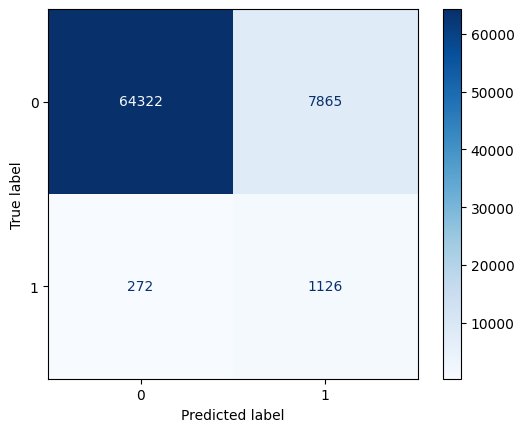

In [50]:
confusion_matrix = confusion_matrix(y_test, y_pred_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot(cmap="Blues")

plt.show()



### Random Forest Classifier

In [51]:
"""
# Forcer l'exécution sur CPU
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
# Nombre d'arbres de ta forêt
n_estimators = 300

# Créer un modèle en mode "warm_start" (permet d’ajouter les arbres un par un)
with tf.device("/CPU:0"):
    rf = RandomForestClassifier(
        n_estimators=1,  # on commence avec 1 arbre
        warm_start=True,
        random_state=42
    )

    # Entraînement incrémental avec tqdm
    for i in tqdm(range(1, n_estimators + 1), desc="Entraînement RF"):
        rf.n_estimators = i
        rf.fit(X_train_df, y_train)
"""

'\n# Forcer l\'exécution sur CPU\nfrom sklearn.ensemble import RandomForestClassifier\nfrom tqdm import tqdm\n# Nombre d\'arbres de ta forêt\nn_estimators = 300\n\n# Créer un modèle en mode "warm_start" (permet d’ajouter les arbres un par un)\nwith tf.device("/CPU:0"):\n    rf = RandomForestClassifier(\n        n_estimators=1,  # on commence avec 1 arbre\n        warm_start=True,\n        random_state=42\n    )\n\n    # Entraînement incrémental avec tqdm\n    for i in tqdm(range(1, n_estimators + 1), desc="Entraînement RF"):\n        rf.n_estimators = i\n        rf.fit(X_train_df, y_train)\n'

In [52]:
"""
# Importance des features
importance_rf = rf.feature_importances_

# Afficher les résultats
feature_importance_rf = pd.DataFrame({
    'Feature': X_train_df.columns,
    'Importance': importance_rf
}).sort_values(by='Importance', ascending=False)

feature_importance_rf.head(20)
"""

"\n# Importance des features\nimportance_rf = rf.feature_importances_\n\n# Afficher les résultats\nfeature_importance_rf = pd.DataFrame({\n    'Feature': X_train_df.columns,\n    'Importance': importance_rf\n}).sort_values(by='Importance', ascending=False)\n\nfeature_importance_rf.head(20)\n"

In [53]:
"""
# Visualiser l'importance des features
plt.figure(figsize=(20, 20))
plt.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'], color='skyblue')
plt.xlabel('Importance des Features')
plt.title('Importance des Features dans le Modèle Random Forest')
plt.show()
"""

"\n# Visualiser l'importance des features\nplt.figure(figsize=(20, 20))\nplt.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'], color='skyblue')\nplt.xlabel('Importance des Features')\nplt.title('Importance des Features dans le Modèle Random Forest')\nplt.show()\n"

### PCA

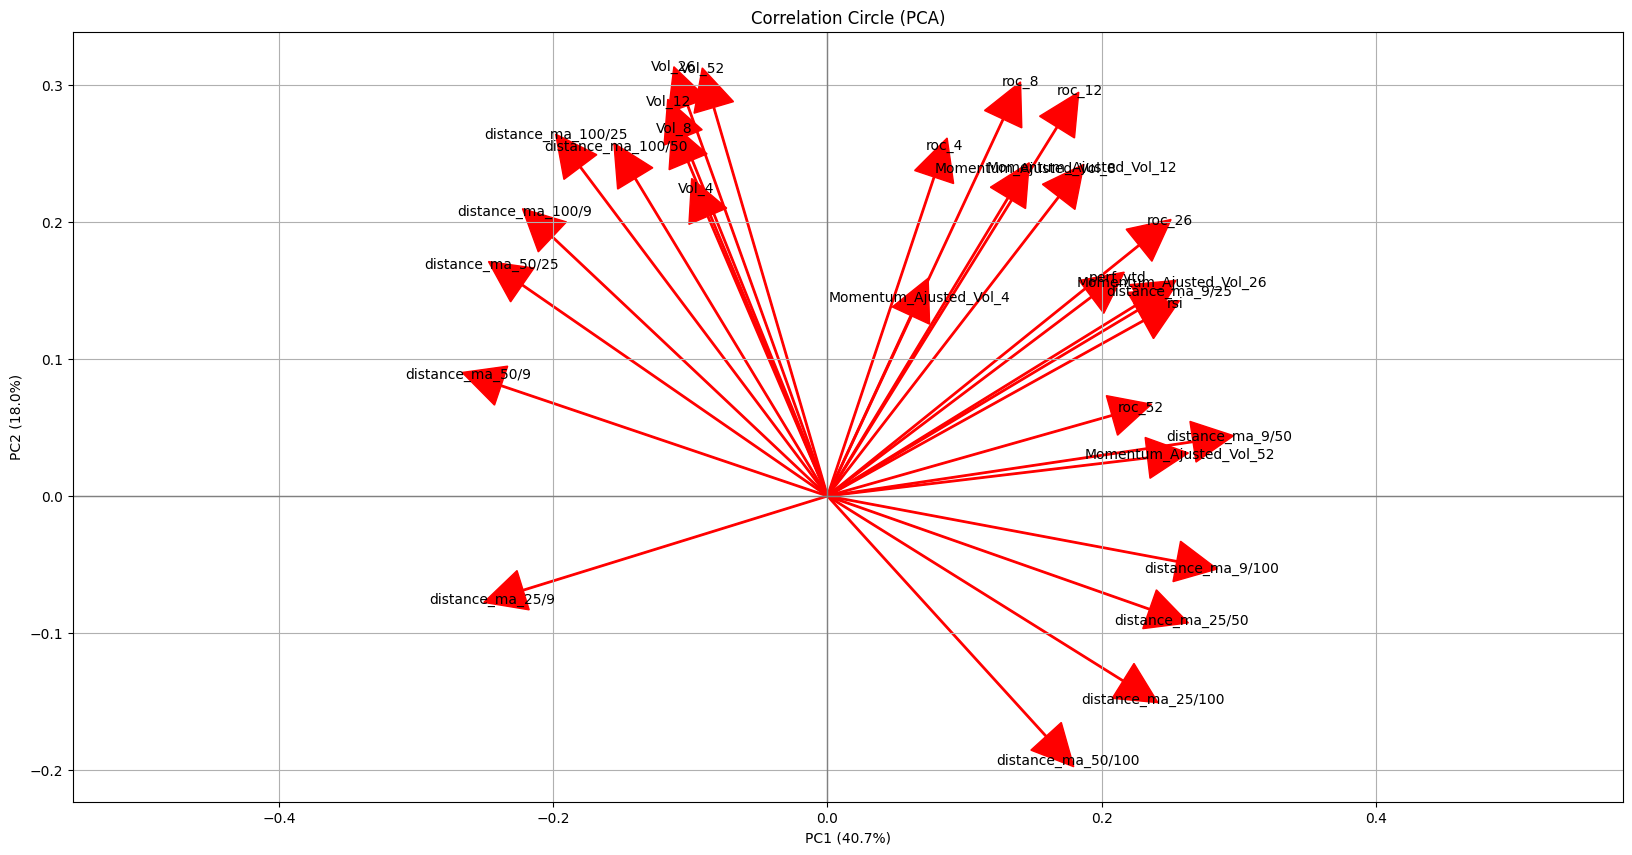

In [54]:

from sklearn.decomposition import PCA

#scaler = StandardScaler()
#X_res = scaler.fit_transform(X_res)

# Apply PCA
pca = PCA(n_components=len(feature_cols))
X_pca = pca.fit_transform(X_train_scale)

# Get the components (loadings)
pcs = pca.components_

# Get the feature names
features =feature_cols

# Correlation circle
plt.figure(figsize=(20, 10))
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)

# Draw unit circle
circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Plot arrows for each feature
for i, feature in enumerate(features):
    plt.arrow(0, 0, pcs[0, i], pcs[1, i], head_width=0.03, head_length=0.03, color='r')
    plt.text(pcs[0, i]*1.1, pcs[1, i]*1.1, feature, color='black', ha='center', va='center')

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Correlation Circle (PCA)")
plt.grid()
plt.axis('equal')
plt.show()

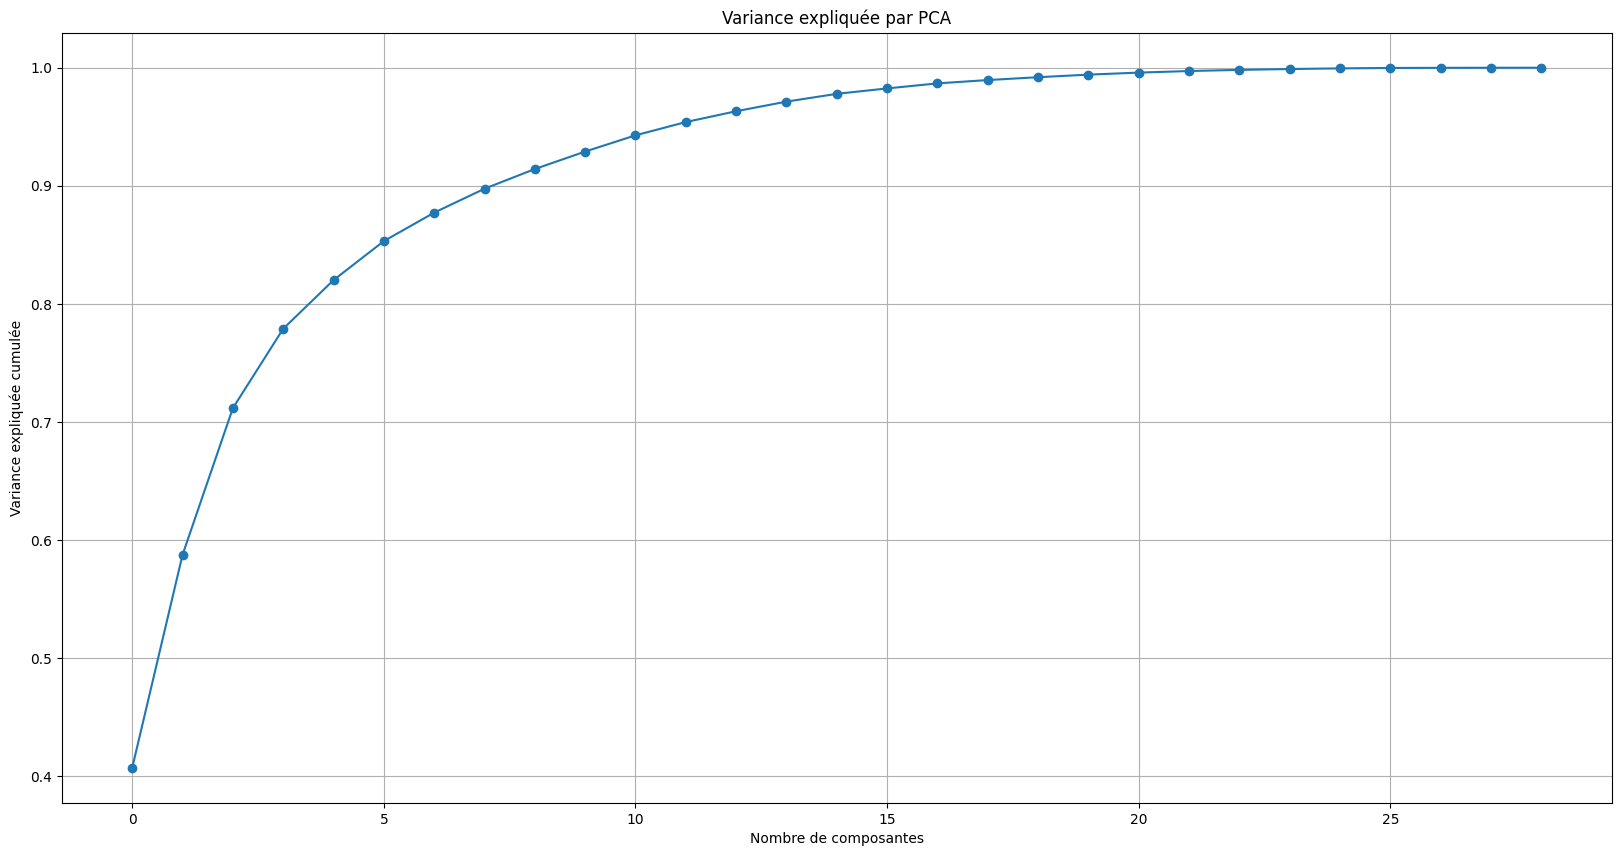

In [55]:

pca = PCA()
pca.fit(X_train_scale)  # X doit être centré-réduit !

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(20, 10))
plt.plot(cumulative_var, marker='o')
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.title("Variance expliquée par PCA")
plt.grid()
plt.show()


### Courbe ROC - AUC

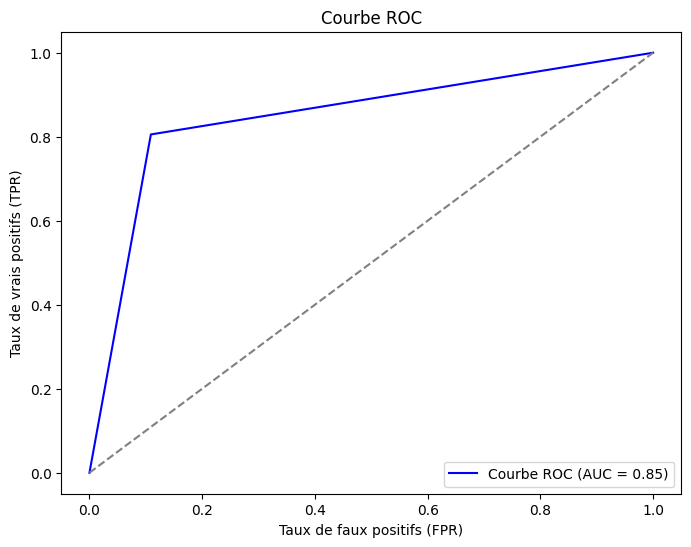

In [56]:
# Calcul des valeurs pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Calcul de l'AUC
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Ligne de référence (modèle aléatoire)
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

# Total Return Model Past Data

### Initialisation

In [57]:
def Calculate_Alpha_Jensen(portfolio_returns: pd.Series,
                          benchmark_returns: pd.Series,
                          risk_free_rate: float = 0.2
                         ) -> float:

    # 2) Estimation de beta
    cov_pm = np.cov(portfolio_returns, benchmark_returns, ddof=0)[0, 0]
    var_m  = np.var(benchmark_returns, ddof=0)
    beta   = cov_pm / var_m

    # 3) Rendement moyen
    mean_port = np.mean(portfolio_returns)
    mean_bench = np.mean(benchmark_returns)

    # 4) Calcul de l'alpha
    expected_port = risk_free_rate + beta * (mean_bench - risk_free_rate)
    alpha = mean_port - expected_port

    return alpha

In [58]:
def Calculate_CAGR(portfolio_returns, annual_returns):

    # Paramètres
    V_fin = portfolio_returns.iloc[-1]
    V_debut = initiale_capital
    t = annual_returns

    # Calculer du CAGR
    CAGR = (((V_fin / V_debut) ** (1 / t)) -1) * 100

    return CAGR

In [59]:
def Calculate_Volatility(returns, periods_per_year = 12):

    vol = returns.std(ddof=1)
    vol *= np.sqrt(periods_per_year)

    return vol

In [60]:
def Calculate_Sharpe_Ratio(returns, vol, risk_free_rate=0.02, periods_per_year=12):

    returns = Calculate_CAGR(returns, len(returns))
    excess_returns = returns - (risk_free_rate / periods_per_year)
    mean_exc = excess_returns.mean() * periods_per_year

    return mean_exc / Calculate_Volatility(vol)

In [61]:
def Calculate_Total_Returns(portfolio_returns):

    Value_start = initiale_capital
    Value_final = portfolio_returns.iloc[-1]

    Total_Returns = (Value_final - Value_start) / Value_start

    return Total_Returns

In [62]:
def Calculate_Max_Drawdown(annual_returns):

    maxdrawdown = annual_returns.min()

    return maxdrawdown

In [63]:
daily_data = pd.DataFrame()
data_SP500 = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_SP500.parquet')
data_NDX = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_NASDAQ.parquet')
data_MP = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_MP.parquet')
data_Crypto = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_Crypto.parquet')
daily_data = pd.concat([data_SP500, data_NDX, data_MP, data_Crypto], ignore_index=True)
daily_data = daily_data.drop_duplicates(subset=['Ticker', 'Date'])

daily_data = daily_data.drop(columns=['Adj Close'])
# trier la data pour préparer la fusion
daily_data = daily_data.sort_values(by=['Date'], ascending=[True])

#Date au format Date
daily_data['Date'] = pd.to_datetime(daily_data['Date'])

# Définir la colonne 'Date' comme index
daily_data.set_index('Date', inplace=True)
daily_data

Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
1976-07-01,0.440307,0.455666,0.440307,0.440307,2.824000e+05,BAC
1976-07-01,0.159507,0.159507,0.157715,0.157715,7.040000e+04,BALL
1976-07-01,0.109001,0.112029,0.109001,0.109001,2.073600e+06,MDT
1976-07-01,0.205049,0.206582,0.203823,0.206275,1.939200e+06,KO
1976-07-01,0.865298,0.871009,0.862442,0.868154,9.496000e+05,CVX
...,...,...,...,...,...,...
2025-09-15,63.130001,63.240002,62.520000,62.970001,9.724000e+03,CL=F
2025-09-15,42.674999,42.840000,42.500000,42.724998,8.619000e+03,SI=F
2025-09-15,3679.500000,3684.300049,3662.800049,3680.199951,3.597300e+04,GC=F


In [64]:
weekly_data = daily_data.groupby("Ticker").resample('W').agg({
    'Open': 'first',   # Premier prix d'ouverture du mois
    'High': 'max',     # Plus haut du mois
    'Low': 'min',      # Plus bas du mois
    'Close': 'last',   # Dernier prix de clôture du mois
    'Volume': 'sum',   # Somme du volume sur le mois
}).reset_index()

In [65]:
# Calculer le rendement pour chaque Ticker avec un décalage d'un mois
weekly_data['Return'] = (weekly_data['Close'] / weekly_data['Open']) -1

# Paramètres
liste_ma = [9, 20, 25, 50, 100]

# Calcul des moyennes mobiles pour chaque fenêtre
for window in liste_ma:
    # Calcul de la moyenne mobile pour chaque 'Ticker'
    ma_column = f'ma_{window}'
    weekly_data[ma_column] = weekly_data.groupby('Ticker')['Close'].transform(lambda s: s.rolling(window, min_periods=1).mean())

liste_ma_1 = [9, 25, 50, 100]
liste_ma_2 = [9, 25, 50, 100]

for window in liste_ma_1:
    for window_2 in liste_ma_2:

        # Calcul de la moyenne mobile pour chaque 'Ticker'
        ma_column_1 = f'ma_{window}'
        ma_column_2 = f'ma_{window_2}'
        distance_ma_column = f'distance_ma_{window_2}/{window}'

        if ma_column_1 != ma_column_2:
            # Calcul du pourcentage d'écart entre le prix et la moyenne mobile
            weekly_data[distance_ma_column] = weekly_data[ma_column_2] / weekly_data[ma_column_1]


list_window = [4, 8, 12, 26, 52] # Liste de valeurs de top_n pour la sélection des meilleurs

# Calcul des performances pour chaque fenêtre
for window in list_window:

    # Nom dynamique de la colonne pour la performance
    roc_column = f'roc_{window}'

    # Calcul de la performance pour chaque 'Ticker' sur la fenêtre spécifiée
    weekly_data[roc_column] = weekly_data.groupby('Ticker')['Close'].pct_change(window)

liste_ma = [9, 25]
for window in liste_ma:

    # Calcul de la moyenne mobile pour chaque 'Ticker'
    distance_price_column = f'distance_price_{window}'
    ma_column = f'ma_{window}'

    # Calcul du pourcentage d'écart entre le prix et la moyenne mobile
    weekly_data[distance_price_column] = weekly_data['Close'] / weekly_data[ma_column]

weekly_data['Year'] = weekly_data['Date'].dt.year

# Close d’ancrage (première observation de l'année par Ticker)
anchor_close = weekly_data.groupby(['Ticker','Year'])['Close'].transform('first')

# Perf YTD (depuis le début d’année)
weekly_data['perf_ytd'] = weekly_data['Close'] / anchor_close - 1

list_window = [4, 8, 12, 26, 52] # Liste de valeurs de top_n pour la sélection des meilleurs

# Calcul des performances pour chaque fenêtre
for window in list_window:

    # Nom dynamique de la colonne pour la performance
    MAV_column = f'Momentum_Ajusted_Vol_{window}'
    Perf_column = f'Perf_{window}'
    Vol_column = f'Vol_{window}'

    # Calcul de la performance pour chaque 'Ticker' sur la fenêtre spécifiée
    weekly_data[Perf_column] = weekly_data.groupby('Ticker')['Close'].pct_change(window)
    weekly_data[Vol_column] = weekly_data.groupby('Ticker')['Return'].rolling(window=window).std().reset_index(level=0, drop=True)
    weekly_data[MAV_column] = weekly_data[Perf_column] / weekly_data[Vol_column]

period = 25

# Variation quotidienne
weekly_data['delta'] = weekly_data.groupby('Ticker')['Close'].diff()

# Gains et pertes
weekly_data['gains'] = weekly_data['delta'].clip(lower=0)
weekly_data['losses'] = -weekly_data['delta'].clip(upper=0)

# Moyenne mobile simple sur 'period' jours
weekly_data['avg_gain'] = (
    weekly_data.groupby('Ticker')['gains']
    .transform(lambda x: x.rolling(window=period, min_periods=period).mean())
)
weekly_data['avg_losses'] = (
    weekly_data.groupby('Ticker')['losses']
    .transform(lambda x: x.rolling(window=period, min_periods=period).mean())
)

# RS et RSI
weekly_data['rs'] = weekly_data['avg_gain'] / weekly_data['avg_losses']
weekly_data['rsi'] = 100 - (100 / (1 + weekly_data['rs']))

#weekly_data = weekly_data.drop(columns=['Return', 'ma_9', 'ma_25', 'ma_50', 'ma_100'])
weekly_data = weekly_data.dropna()

/var/folders/6k/82j2nnl13hj9ld7nmzpdt6fh0000gn/T/ipykernel_2228/3999834889.py:38: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  weekly_data[roc_column] = weekly_data.groupby('Ticker')['Close'].pct_change(window)
/var/folders/6k/82j2nnl13hj9ld7nmzpdt6fh0000gn/T/ipykernel_2228/3999834889.py:38: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  weekly_data[roc_column] = weekly_data.groupby('Ticker')['Close'].pct_change(window)
/var/folders/6k/82j2nnl13hj9ld7nmzpdt6fh0000gn/T/ipykernel_2228/3999834889.py:38: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is 

In [66]:
start_date = "1990-01-01"

weekly_data = weekly_data[weekly_data['Date'] >= start_date]

weekly_data = weekly_data.replace([np.inf, -np.inf], 0)
#weekly_data = weekly_data.drop(columns=['Close', 'Open', 'High', 'Low', 'Volume'])
# Remplacer les valeurs NaN par 0
weekly_data = weekly_data.dropna()

weekly_data

Price,Ticker,Date,Open,High,Low,Close,Volume,Return,ma_9,ma_20,...,Perf_52,Vol_52,Momentum_Ajusted_Vol_52,delta,gains,losses,avg_gain,avg_losses,rs,rsi
52,A,2000-11-19,23.512443,28.499929,22.837444,28.424927,22982282.0,0.208931,28.095763,30.869924,...,0.173375,0.160231,1.082027,4.762493,4.762493,-0.000000,1.801493,2.224493,0.809845,44.746636
53,A,2000-11-26,28.124937,30.899933,26.287439,30.562435,19656719.0,0.086667,28.158262,30.373050,...,0.236723,0.160547,1.474477,2.137508,2.137508,-0.000000,1.484995,2.224493,0.667566,40.032350
54,A,2000-12-03,30.562427,32.812430,29.999928,31.799932,19512026.0,0.040491,28.429097,29.651178,...,0.191012,0.160276,1.191771,1.237497,1.237497,-0.000000,1.534495,1.963494,0.781513,43.867922
55,A,2000-12-10,31.237410,35.924906,30.299913,35.662407,20204315.0,0.141657,28.912430,29.992427,...,0.328212,0.161222,2.035779,3.862474,3.862474,-0.000000,1.688994,1.765494,0.956669,48.892746
56,A,2000-12-17,35.174919,35.812417,32.699926,34.124924,19708864.0,-0.029851,29.745762,30.461177,...,0.238095,0.161345,1.475689,-1.537483,0.000000,1.537483,1.388995,1.826993,0.760263,43.190305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809572,ZTS,2025-08-17,147.669998,155.100006,147.350006,154.110001,15245700.0,0.043611,152.772090,155.818647,...,-0.150918,0.029191,-5.169934,6.759995,6.759995,-0.000000,1.893459,2.104556,0.899696,47.359988
809573,ZTS,2025-08-24,154.000000,160.479996,151.600006,156.619995,12640900.0,0.017013,152.769179,156.113860,...,-0.123685,0.029255,-4.227880,2.509995,2.509995,-0.000000,1.724473,2.104556,0.819400,45.036822
809574,ZTS,2025-08-31,156.759995,157.210007,153.289993,156.399994,10709200.0,-0.002297,152.852563,156.511806,...,-0.137268,0.029173,-4.705350,-0.220001,0.000000,0.220001,1.600110,2.113356,0.757142,43.089395
809575,ZTS,2025-09-07,154.979996,155.380005,151.350006,153.320007,7327400.0,-0.010711,152.260398,156.793997,...,-0.179912,0.028696,-6.269657,-3.079987,0.000000,3.079987,1.600110,1.874591,0.853578,46.050290


In [67]:

# 1) Télécharger les cours mensuels ajustés du S&P 500
ndx = yf.download(
    "^GSPC",
    start="1976-07-01",
    end="2025-07-17",
    interval="1wk",
    auto_adjust=True,
    actions=False
)[["Open", "Close"]]

ndx.columns = ndx.columns.droplevel(level=1)

ndx.columns = ['ndx_Open', 'ndx_Close']

# 2) Convertir l’index en période mensuelle, puis au TIMESTAMP de fin de mois
ndx.index = pd.to_datetime(ndx.index)

# 3) Normaliser pour que le S&P 500 commence à la même valeur que le capital initial
ndx['Return'] = (ndx['ndx_Close'].pct_change()).fillna(0)

# Calcul des moyennes mobiles pour chaque fenêtre
ndx['Slow_ma'] = ndx['ndx_Close'].rolling(window=25, min_periods=1).mean()
ndx['Fast_ma'] = ndx['ndx_Close'].rolling(window=9, min_periods=1).mean()

crisis = []
for i in range(0, len(ndx)):
    if ndx['Slow_ma'].iloc[i] < ndx['Fast_ma'].iloc[i] and ndx['Slow_ma'].iloc[i] < ndx['ndx_Close'].iloc[i]:
        crisis.append(0)
    elif ndx['Slow_ma'].iloc[i] > ndx['Fast_ma'].iloc[i] and ndx['Fast_ma'].iloc[i] < ndx['ndx_Close'].iloc[i]:
        crisis.append(0)
    else:
        crisis.append(0)

ndx['Crisis'] = crisis

ndx = ndx.fillna(0)
ndx = ndx.drop(columns=['ndx_Open', 'ndx_Close','Return', 'Slow_ma', 'Fast_ma'])

weekly_data = pd.merge_asof(
    weekly_data.sort_values('Date'),
    ndx.sort_values('Date'),
    on='Date',
    direction='backward'
)

#data = data[data['Crisis'] == 0]


[*********************100%***********************]  1 of 1 completed


In [68]:
#data = data.drop(columns=['distance_ma_25/9', 'distance_ma_50/9', 'distance_ma_100/9', 'distance_ma_25/50', 'distance_ma_50/100', 'distance_ma_25/100'])

In [69]:
feature_cols

['distance_ma_25/9',
 'distance_ma_50/9',
 'distance_ma_100/9',
 'distance_ma_9/25',
 'distance_ma_50/25',
 'distance_ma_100/25',
 'distance_ma_9/50',
 'distance_ma_25/50',
 'distance_ma_100/50',
 'distance_ma_9/100',
 'distance_ma_25/100',
 'distance_ma_50/100',
 'rsi',
 'roc_4',
 'roc_8',
 'roc_12',
 'roc_26',
 'roc_52',
 'Vol_4',
 'Momentum_Ajusted_Vol_4',
 'Vol_8',
 'Momentum_Ajusted_Vol_8',
 'Vol_12',
 'Momentum_Ajusted_Vol_12',
 'Vol_26',
 'Momentum_Ajusted_Vol_26',
 'Vol_52',
 'Momentum_Ajusted_Vol_52',
 'perf_ytd']

In [70]:
X = weekly_data[[
'distance_ma_25/9',
 'distance_ma_50/9',
 'distance_ma_100/9',
 'distance_ma_9/25',
 'distance_ma_50/25',
 'distance_ma_100/25',
 'distance_ma_9/50',
 'distance_ma_25/50',
 'distance_ma_100/50',
 'distance_ma_9/100',
 'distance_ma_25/100',
 'distance_ma_50/100',
 'rsi',
 'roc_4',
 'roc_8',
 'roc_12',
 'roc_26',
 'roc_52',
 'Vol_4',
 'Momentum_Ajusted_Vol_4',
 'Vol_8',
 'Momentum_Ajusted_Vol_8',
 'Vol_12',
 'Momentum_Ajusted_Vol_12',
 'Vol_26',
 'Momentum_Ajusted_Vol_26',
 'Vol_52',
 'Momentum_Ajusted_Vol_52',
 'perf_ytd']]

X_scale_test = scaler.fit_transform(X)
weekly_data['Proba'] = best_model.predict(X_scale_test).ravel()


21572/21572 ━━━━━━━━━━━━━━━━━━━━ 8s 372us/step


In [302]:
weekly_data['Prediction'] = (weekly_data['Proba'] > 0.7).astype(int)
weekly_data['Prediction'].value_counts()

Prediction
0    672365
1     17914
Name: count, dtype: int64

### Backtest

In [303]:
data = weekly_data.copy()

In [304]:
import numpy as np
import pandas as pd

def backtest(
    data: pd.DataFrame,
    initial_capital: float,
    save_month: float,
    fee_per_trade: float,
    moving_average_buy: int,
    moving_average_sell: int,
    proba_column: str = "Proba",
    max_positions: int = 10,   # plafond de positions
):
    """
    Colonnes requises dans `data` :
      - Date (datetime64)
      - Ticker (str)
      - Open (float), Close (float)
      - Prediction (0/1)
      - Return (float)       → rendement de la période SUIVANTE (t+1)
      - ma_{moving_average_buy}, ma_{moving_average_sell}
      - Crisis (0/1)         → 1 = crise (on reste cash), 0 = normal
      - Proba (float)        → optionnelle, sert à pondérer / classer
    """

    # --- vérifs & pré-tri ---
    ma_buy  = f"ma_{moving_average_buy}"
    ma_sell = f"ma_{moving_average_sell}"
    required = ["Date","Ticker","Open","Close","Prediction","Return",ma_buy,ma_sell,"Crisis"]
    missing = [c for c in required if c not in data.columns]
    if missing:
        raise ValueError(f"Colonnes manquantes: {missing}")

    df = data.sort_values(["Date", "Ticker"]).copy()
    unique_dates = np.sort(df["Date"].unique())

    # --- états backtest ---
    capital = float(initial_capital)
    previous_portfolio: set[str] = set()

    capital_hist, ret_hist = [], []
    count_hist, fees_hist = [], []
    opened_hist, closed_hist, total_hist = [], [], []
    tickers_history: dict = {}

    # --- boucle principale ---
    for i, date in enumerate(unique_dates):
        capital += float(save_month)

        # Slice du jour
        cols_today = ["Ticker","Open","Close","Prediction","Return","Crisis",ma_buy,ma_sell, 'rsi']
        if proba_column in df.columns:
            cols_today.append(proba_column)
        today = df.loc[df["Date"] == date, cols_today].copy()

        if today.empty:
            # sécurité (au cas improbable)
            capital_hist.append(capital)
            ret_hist.append(0.0)
            count_hist.append(len(previous_portfolio))
            fees_hist.append(0.0)
            opened_hist.append(0)
            closed_hist.append(0)
            total_hist.append(0)
            continue

        crisis_flag = int(today["Crisis"].iloc[0])

        # --------- déterminer le portefeuille courant ---------
        if crisis_flag == 1:
            # En crise : on vend tout, reste en cash
            current_portfolio = set()
            #sell_set = previous_portfolio  # tout doit être vendu
            #buy_set = set()
        else:
            # Pas de crise → règles normales BUY/SELL
            buy_candidates = today.loc[
                (today[ma_buy] < today["Open"]) &
                (today[ma_buy] < today["Close"]) &
                (today["Prediction"] == 1),
                "Ticker"
            ]
            sell_candidates = today.loc[(
                    (today[ma_sell] > today["Open"]) &
                    (today[ma_sell] > today["Close"])),
                "Ticker"
            ]
            buy_set  = set(buy_candidates)
            sell_set = set(sell_candidates)

            # Portefeuille après ventes
            held_after_sell = previous_portfolio - sell_set
            new_buys = buy_set - previous_portfolio

            # ----- classement par score pour bornage à max_positions -----
            # Score = Proba si dispo/valide, sinon momentum simple
            today_idx = today.set_index("Ticker")
            if (proba_column in today_idx.columns) and today_idx[proba_column].notna().any():
                score_map = today_idx[proba_column].fillna(0.0).to_dict()
            else:
                # momentum proxy : Close/ma_buy - 1 (plus c'est grand, mieux c'est)
                mom = (today_idx["Close"] / today_idx[ma_buy] - 1.0)
                mom = mom.replace([np.inf, -np.inf], np.nan).fillna(0.0)
                score_map = mom.to_dict()

            # 1) on garde les positions détenues (après ventes), triées par score
            held_sorted = sorted(list(held_after_sell), key=lambda t: score_map.get(t, 0.0), reverse=True)

            if len(held_sorted) >= max_positions:
                # Trop de positions : on coupe les moins bien classées
                current_portfolio = set(held_sorted[:max_positions])
            else:
                # On complète avec les nouveaux BUY les mieux classés
                remaining = max_positions - len(held_sorted)
                new_sorted = sorted(list(new_buys), key=lambda t: score_map.get(t, 0.0), reverse=True)
                add_these = new_sorted[:remaining]
                current_portfolio = set(held_sorted + add_these)

        # --------- frais fixes (ouvertures / fermetures) ---------
        opened = current_portfolio - previous_portfolio
        closed = previous_portfolio - current_portfolio
        n_opened = len(opened)
        n_closed = len(closed)
        n_total  = n_opened + n_closed
        fees_paid = n_total * float(fee_per_trade)
        capital -= fees_paid  # débit immédiat

        # --------- préparer les retours t+1 ---------
        holdings = pd.DataFrame({"Ticker": list(current_portfolio)})
        if i + 1 < len(unique_dates) and not holdings.empty:
            next_date = unique_dates[i + 1]
            next_ret = df.loc[df["Date"] == next_date, ["Ticker","Return"]]

            merged = holdings.merge(next_ret, on="Ticker", how="left")

            # Ajoute la proba du jour pour pondérer si dispo
            if proba_column in today.columns:
                merged = merged.merge(today[["Ticker", proba_column]], on="Ticker", how="left")

            # On ne garde que ceux qui ont un Return observé à t+1
            merged = merged.dropna(subset=["Return"]).reset_index(drop=True)
            # Met à jour le portefeuille (au cas où certains titres n’ont pas de Return)
            current_portfolio = set(merged["Ticker"])

            # Poids cibles
            r = merged["Return"].astype(float).to_numpy()
            if proba_column in merged.columns:
                p = merged[proba_column].fillna(0.0).astype(float).to_numpy()
                w = (p / p.sum()) if p.sum() > 0 else np.ones_like(r) / max(len(r), 1)
            else:
                w = np.ones_like(r) / max(len(r), 1)

            mean_return = float(np.dot(r, w))
        else:
            # pas de prochaine date ou portefeuille vide → pas de perf
            merged = holdings.copy()
            merged["Return"] = 0.0
            if proba_column in today.columns:
                merged[proba_column] = np.nan
            mean_return = 0.0

        # --------- appliquer rendement ---------
        capital *= (1.0 + mean_return)

        # --------- historique ---------
        tickers_history[date] = merged.copy()
        capital_hist.append(capital)
        ret_hist.append(mean_return)
        count_hist.append(len(current_portfolio))
        fees_hist.append(fees_paid)
        opened_hist.append(n_opened)
        closed_hist.append(n_closed)
        total_hist.append(n_total)

        # t devient t-1
        previous_portfolio = current_portfolio

    # --------- sorties agrégées ---------
    portfolio_per_day = pd.DataFrame({
        "Date": unique_dates,
        "Capital": capital_hist,
        "Return": np.array(ret_hist) * 100.0,
        "Ticker_Count": count_hist,
        "Fees": fees_hist,
        "Trades_Opened": opened_hist,
        "Trades_Closed": closed_hist,
        "Trades_Total": total_hist,
    }).set_index("Date")

    # Mensuel
    monthly = portfolio_per_day.resample("ME").agg({
        "Capital": "last",
        "Ticker_Count": "mean",
        "Fees": "sum",
        "Trades_Opened": "sum",
        "Trades_Closed": "sum",
        "Trades_Total": "sum",
    })
    first_cap_m = portfolio_per_day["Capital"].resample("ME").first().ffill()
    last_cap_m  = portfolio_per_day["Capital"].resample("ME").last().ffill()
    monthly["Return"] = ((last_cap_m / first_cap_m - 1.0) * 100.0).fillna(0.0)

    # Annuel
    annual = portfolio_per_day.resample("YE").agg({
        "Capital": "last",
        "Ticker_Count": "mean",
        "Fees": "sum",
        "Trades_Opened": "sum",
        "Trades_Closed": "sum",
        "Trades_Total": "sum",
    })
    first_cap_y = portfolio_per_day["Capital"].resample("YE").first().ffill()
    last_cap_y  = portfolio_per_day["Capital"].resample("YE").last().ffill()
    annual["Return"] = ((last_cap_y / first_cap_y - 1.0) * 100.0).fillna(0.0)

    return portfolio_per_day, monthly, annual, tickers_history

In [305]:
initiale_capital = 1000
portfolio_per_day, portfolio_per_month, portfolio_per_annual, list_ticker = backtest(weekly_data, initial_capital=initiale_capital, save_month=0, fee_per_trade=1, moving_average_buy=9, moving_average_sell=25)

In [306]:
worst = portfolio_per_month[portfolio_per_month['Return'] < 0]
worst = worst.sort_values(by=['Return'], ascending=True)
print(len(portfolio_per_month), len(worst), len(worst)/len(portfolio_per_month)*100)

429 161 37.52913752913753


In [307]:
worst.head(10)

,Capital,Ticker_Count,Fees,Trades_Opened,Trades_Closed,Trades_Total,Return
Date,,,,,,,
2008-07-31,1.298096e+06,2.00,4.0,1,3,4,-21.910707
2021-02-28,9.732946e+07,10.00,0.0,0,0,0,-20.976975
2022-06-30,1.204082e+08,8.50,4.0,0,4,4,-20.252321
1998-08-31,2.313587e+04,8.20,7.0,2,5,7,-19.190264
2024-07-31,3.850413e+08,10.00,6.0,3,3,6,-19.069748
2008-09-30,1.047395e+06,1.75,1.0,0,1,1,-18.692894
1997-10-31,2.212153e+04,10.00,6.0,3,3,6,-17.001055
2010-01-31,1.973622e+06,10.00,2.0,1,1,2,-16.744498
2025-02-28,8.228331e+08,9.75,4.0,2,2,4,-16.201496


In [308]:
portfolio_per_day['Ticker_Count'].describe()

count    1864.000000
mean        8.396996
std         2.437872
min         0.000000
25%         8.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: Ticker_Count, dtype: float64

In [309]:
portfolio_per_annual

,Capital,Ticker_Count,Fees,Trades_Opened,Trades_Closed,Trades_Total,Return
Date,,,,,,,
1990-12-31,8.256675e+02,3.884615,26.0,17,9,26,-17.433252
1991-12-31,2.559700e+03,9.673077,14.0,9,5,14,212.842243
1992-12-31,3.394475e+03,7.634615,35.0,17,18,35,25.977970
1993-12-31,5.118033e+03,9.980769,27.0,14,13,27,53.589359
1994-12-31,9.399238e+03,7.673077,32.0,16,16,32,84.155456
1995-12-31,1.627858e+04,9.471698,30.0,15,15,30,71.515591
1996-12-31,1.850004e+04,9.173077,36.0,18,18,36,15.378931
1997-12-31,2.138722e+04,8.846154,39.0,19,20,39,10.809573
1998-12-31,2.952602e+04,8.615385,37.0,19,18,37,42.190114


In [310]:
list_ticker

{np.datetime64('1990-01-07T00:00:00.000000000'): Empty DataFrame
 Columns: [Ticker, Return, Proba]
 Index: [],
 np.datetime64('1990-01-14T00:00:00.000000000'): Empty DataFrame
 Columns: [Ticker, Return, Proba]
 Index: [],
 np.datetime64('1990-01-21T00:00:00.000000000'): Empty DataFrame
 Columns: [Ticker, Return, Proba]
 Index: [],
 np.datetime64('1990-01-28T00:00:00.000000000'): Empty DataFrame
 Columns: [Ticker, Return, Proba]
 Index: [],
 np.datetime64('1990-02-04T00:00:00.000000000'): Empty DataFrame
 Columns: [Ticker, Return, Proba]
 Index: [],
 np.datetime64('1990-02-11T00:00:00.000000000'): Empty DataFrame
 Columns: [Ticker, Return, Proba]
 Index: [],
 np.datetime64('1990-02-18T00:00:00.000000000'): Empty DataFrame
 Columns: [Ticker, Return, Proba]
 Index: [],
 np.datetime64('1990-02-25T00:00:00.000000000'): Empty DataFrame
 Columns: [Ticker, Return, Proba]
 Index: [],
 np.datetime64('1990-03-04T00:00:00.000000000'): Empty DataFrame
 Columns: [Ticker, Return, Proba]
 Index: [],
 

In [311]:
list_ticker.items()

dict_items([(np.datetime64('1990-01-07T00:00:00.000000000'), Empty DataFrame
Columns: [Ticker, Return, Proba]
Index: []), (np.datetime64('1990-01-14T00:00:00.000000000'), Empty DataFrame
Columns: [Ticker, Return, Proba]
Index: []), (np.datetime64('1990-01-21T00:00:00.000000000'), Empty DataFrame
Columns: [Ticker, Return, Proba]
Index: []), (np.datetime64('1990-01-28T00:00:00.000000000'), Empty DataFrame
Columns: [Ticker, Return, Proba]
Index: []), (np.datetime64('1990-02-04T00:00:00.000000000'), Empty DataFrame
Columns: [Ticker, Return, Proba]
Index: []), (np.datetime64('1990-02-11T00:00:00.000000000'), Empty DataFrame
Columns: [Ticker, Return, Proba]
Index: []), (np.datetime64('1990-02-18T00:00:00.000000000'), Empty DataFrame
Columns: [Ticker, Return, Proba]
Index: []), (np.datetime64('1990-02-25T00:00:00.000000000'), Empty DataFrame
Columns: [Ticker, Return, Proba]
Index: []), (np.datetime64('1990-03-04T00:00:00.000000000'), Empty DataFrame
Columns: [Ticker, Return, Proba]
Index: [])

In [312]:
# 1) Calculer le drawdown mensuel
#    drawdown = (Capital / pic_historique) - 1
portfolio_per_day['Peak'] = portfolio_per_day['Capital'].cummax()
portfolio_per_day['Drawdown'] = portfolio_per_day['Capital'] / portfolio_per_day['Peak'] - 1

# 2) Résultat : série mensuelle de drawdowns
#    Le drawdown est négatif (0 au pic, baisse ensuite)  [oai_citation:0‡reddit.com](https://www.reddit.com/r/learnpython/comments/bxyze5/getting_max_drawdown_with_python/?utm_source=chatgpt.com)

# 3) Calculer le max drawdown global
max_dd_global = portfolio_per_day['Drawdown'].min()

# 4) Calculer le drawdown maximal par année
#    On regroupe par année et on prend le minimum (le plus négatif) de Drawdown
mensuel_max_dd = (
    portfolio_per_day['Drawdown']
    .groupby(portfolio_per_day.index.year)
    .min()
    .rename('MaxDrawdown')
    .to_frame()
)

# Calcul du nombre d'actions sélectionnées chaque mois
monthly_counts = data.groupby('Date')['Prediction'].sum()
monthly_counts.index = pd.to_datetime(monthly_counts.index)

# Moyenne des sélections mensuelles
average_count = monthly_counts.mean()

# 1) Regrouper par année (resample('Y') pour Year-End)
annual_counts = monthly_counts.resample('YE').sum()

# 2) Calculer la moyenne annuelle des sélections
average_annual_count = annual_counts.mean()


In [313]:
data = data.sort_values('Date')
# 1) Télécharger les cours mensuels ajustés du S&P 500
ndx = yf.download(
    "^GSPC",
    start=data['Date'].iloc[0],
    end=data['Date'].iloc[-1],
    interval="1wk",
    auto_adjust=True,
    actions=False
)["Close"]
# 2) Convertir l’index en période mensuelle, puis au TIMESTAMP de fin de mois
ndx.index = pd.to_datetime(ndx.index)

# 3) Normaliser pour que le S&P 500 commence à la même valeur que le capital initial
ndx_return = (ndx.pct_change())

# 4) Reindexer ndx_norm sur l’index de portfolio_per_month (remplit les mois manquants par propagation)
ndx_return = ndx_return.reindex(portfolio_per_day.index, method="ffill")

# 5) Fusionner dans df_bench
portfolio_per_day["S&P500_return"] = ndx_return
portfolio_per_day["S&P500_return"].fillna(0)

initial_cap_ndx = portfolio_per_day["Capital"].iloc[0]
portfolio_per_day["S&P500_capital"] = (1 + portfolio_per_day["S&P500_return"]).cumprod() * initial_cap_ndx
portfolio_per_day['S&P500_return'] = portfolio_per_day['S&P500_return'] * 100

# 1) Calculer le drawdown mensuel
#    drawdown = (Capital / pic_historique) - 1
portfolio_per_day['S&P500_Peak'] = portfolio_per_day['S&P500_capital'].cummax()
portfolio_per_day['S&P500_Drawdown'] = portfolio_per_day['S&P500_capital'] / portfolio_per_day['S&P500_Peak'] - 1

# 3) Calculer le max drawdown global
max_dd_global_ndx = portfolio_per_day['S&P500_Drawdown'].min()

# 4) Calculer le drawdown maximal par année
#    On regroupe par année et on prend le minimum (le plus négatif) de Drawdown
mensuel_max_dd_ndx = (
    portfolio_per_day['S&P500_Drawdown']
    .groupby(portfolio_per_day.index.year)
    .min()
    .rename('MaxDrawdown')
    .to_frame()
)

portfolio_per_month = portfolio_per_day.resample('ME').agg({
    'Capital': 'last',
    'Ticker_Count': 'mean',
    'Drawdown': 'min',
    'S&P500_capital': 'last',
    'S&P500_Drawdown': 'min'
})
first_capital_month = portfolio_per_day['Capital'].resample('ME').first().ffill()
last_capital_month = portfolio_per_day['Capital'].resample('ME').last().ffill()
first_capital_ndx_month = portfolio_per_day['S&P500_capital'].resample('ME').first().ffill()
last_capital_ndx_month = portfolio_per_day['S&P500_capital'].resample('ME').last().ffill()

portfolio_per_month['Return'] = ((last_capital_month / first_capital_month - 1) * 100).fillna(0)
portfolio_per_month['S&P500_return'] = ((last_capital_ndx_month / first_capital_ndx_month - 1) * 100).fillna(0)

portfolio_per_annual = portfolio_per_day.resample('YE').agg({
    'Capital': 'last',
    'Ticker_Count': 'mean',
    'Drawdown': 'min',
    'S&P500_capital': 'last',
    'S&P500_Drawdown': 'min'
})
first_capital_year = portfolio_per_day['Capital'].resample('YE').first().ffill()
first_capital_ndx_year = portfolio_per_day['S&P500_capital'].resample('YE').first().ffill()
last_capital_year = portfolio_per_day['Capital'].resample('YE').last().ffill()
last_capital_ndx_year = portfolio_per_day['S&P500_capital'].resample('YE').first().ffill()

portfolio_per_annual['Return'] = ((last_capital_year / first_capital_year - 1) * 100).fillna(0)
portfolio_per_annual['S&P500_return'] = ((last_capital_ndx_year / first_capital_ndx_year - 1) * 100).fillna(0)

[*********************100%***********************]  1 of 1 completed


In [314]:
comparaison_benchmark = portfolio_per_month[portfolio_per_month['Return'] < portfolio_per_month['S&P500_return']].sort_values(by=['Date'], ascending=True)
print(len(comparaison_benchmark)/len(portfolio_per_month))
comparaison_benchmark.head(10)

0.37995337995337997


,Capital,Ticker_Count,Drawdown,S&P500_capital,S&P500_Drawdown,Return,S&P500_return
Date,,,,,,,
1990-04-30,987.177344,3.60,-0.197991,968.169895,-0.044230,-6.143319,-3.185861
1990-05-31,990.956217,4.75,-0.159366,1043.097091,-0.017279,-2.098984,4.784412
1990-07-31,971.934413,8.60,-0.175503,1039.743506,-0.037761,-5.801892,-1.279254
1990-11-30,825.945056,4.50,-0.303213,926.955588,-0.150990,-4.957020,1.042168
1990-12-31,825.667477,5.40,-0.299582,967.022647,-0.122757,-2.367125,2.017255
1991-04-30,1407.084499,10.00,-0.012682,1114.994255,-0.013483,-1.268193,0.975065
1992-02-29,2620.790734,10.00,-0.044695,1210.337427,-0.025182,-4.426592,0.648269
1992-04-30,2397.422429,9.75,-0.125723,1203.247721,-0.042424,-6.156168,1.860292
1992-05-31,2405.432468,8.20,-0.148992,1221.869253,-0.022058,-1.425243,0.683588


### Visualisation

In [315]:
CAGR_Portfolio = Calculate_CAGR(portfolio_per_annual['Capital'], len(portfolio_per_annual)).round(2)
CAGR_ndx = Calculate_CAGR(portfolio_per_annual['S&P500_capital'], len(portfolio_per_annual)).round(2)
print(f'CAGR_Portfolio:{CAGR_Portfolio}')
print(f'CAGR_ndx:{CAGR_ndx}')

CAGR_Portfolio:47.01
CAGR_ndx:8.63


In [316]:
Alpha_Portfolio = Calculate_Alpha_Jensen(portfolio_per_day['Return'], portfolio_per_day['S&P500_return'])
print(f'Alpha_Portfolio:{Alpha_Portfolio}')

Alpha_Portfolio:0.7184855921683853


In [317]:
Sharpe_Portfolio = Calculate_Sharpe_Ratio(portfolio_per_month['Capital'], portfolio_per_month['Return']).round(2)
Sharpe_ndx = Calculate_Sharpe_Ratio(portfolio_per_month['S&P500_capital'], portfolio_per_month['S&P500_return']).round(2)
print(f'Sharpe_Portfolio:{Sharpe_Portfolio}')
print(f'Sharpe_ndx:{Sharpe_ndx}')

Sharpe_Portfolio:1.27
Sharpe_ndx:0.6


In [318]:
Total_Returns_Portfolio = Calculate_Total_Returns(portfolio_per_month['Capital']).round(2)
Total_Returns_ndx = Calculate_Total_Returns(portfolio_per_month['S&P500_capital']).round(2)
print(f'Total_Return_Portfolio:{Total_Returns_Portfolio}')
print(f'Total_Return_ndx:{Total_Returns_ndx}')

Total_Return_Portfolio:1057258.04
Total_Return_ndx:18.68


In [319]:
Max_Drawdown_Portfolio = Calculate_Max_Drawdown(portfolio_per_day['Return']).round(2)
Max_Drawdown_ndx = Calculate_Max_Drawdown(portfolio_per_day['S&P500_return']).round(2)
print(f'Max_Drawdown_Portfolio:{Max_Drawdown_Portfolio}')
print(f'Max_Drawdown_ndx:{Max_Drawdown_ndx}')

Max_Drawdown_Portfolio:-28.4
Max_Drawdown_ndx:-18.2


In [320]:
Volatility_Portfolio = Calculate_Volatility(portfolio_per_month['Return']).round(2)
Volatility_ndx = Calculate_Volatility(portfolio_per_month['S&P500_return']).round(2)
print(f'Volatility_Portfolio:{Volatility_Portfolio}')
print(f'Volatility_ndx:{Volatility_ndx}')

Volatility_Portfolio:31.01
Volatility_ndx:13.93


In [321]:
# 6) Tracer l’évolution du capital vs benchmark (échelle log)
fig = px.line(
    portfolio_per_month.reset_index(),
    x="Date",
    y=["Capital", "S&P500_capital"],
    title="Évolution du capital vs S&P 500 (benchmark)",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)

fig.update_yaxes(type="log")  # axe Y en échelle logarithmique
fig.update_layout(
    xaxis_tickformat="%Y-%m",
    xaxis_title="Mois",
    yaxis_title="Valeur (log)",
    legend_title="Courbes"
)
fig.show()

fig = px.bar(
    portfolio_per_month.reset_index(),
    x="Date",
    y=["Return", "S&P500_return"],
    barmode="group",
    title="Return evolution vs S&P500 (benchmark)",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)
# axe Y en échelle logarithmique
fig.update_layout(
    xaxis_tickformat="%Y-%m",
    xaxis_title="Mois",
    yaxis_title="Valeur (log)",
    legend_title="Courbes"
)
fig.show()

fig = px.area(
    portfolio_per_month.reset_index(),
    x='Date',
    y=["Drawdown", "S&P500_Drawdown"],
    title="Drawdown mensuel",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)
fig.update_layout(
    xaxis_tickformat='%Y-%m',
    yaxis_tickformat='%.0%',
    yaxis_title="Drawdown",
)
fig.show()

fig = px.bar(
    portfolio_per_month.reset_index(),
    x="Date",
    y="Ticker_Count",
    title="Counts tickers by month",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)
# axe Y en échelle logarithmique
fig.update_layout(
    xaxis_tickformat="%Y-%m",
    xaxis_title="Mois",
    yaxis_title="Valeur (log)",
    legend_title="Courbes"
)
fig.show()

fig = px.line(
    portfolio_per_annual.reset_index(),
    x="Date",
    y=["Capital", "S&P500_capital"],
    title="Évolution du capital vs S&P500 (benchmark)",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)

fig.update_yaxes(type="log")  # axe Y en échelle logarithmique
fig.update_layout(
    xaxis_tickformat="%Y-%m",
    xaxis_title="Mois",
    yaxis_title="Valeur (log)",
    legend_title="Courbes"
)
fig.show()

fig = px.bar(
    portfolio_per_annual.reset_index(),
    x="Date",
    y=["Return", "S&P500_return"],
    barmode="group",
    title="Return evolution vs S&P500 (benchmark)",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)
# axe Y en échelle logarithmique
fig.update_layout(
    xaxis_tickformat="%Y-%m",
    xaxis_title="Mois",
    yaxis_title="Valeur (log)",
    legend_title="Courbes"
)
fig.show()

fig = px.area(
    portfolio_per_annual.reset_index(),
    x='Date',
    y=["Drawdown", "S&P500_Drawdown"],
    title="Drawdown annuel",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)
fig.update_layout(
    xaxis_tickformat='%Y-%m',
    yaxis_tickformat='%.0%',
    yaxis_title="Drawdown",
)
fig.show()